# Generative Adversarial Networks


<center><img src="https://i.imgur.com/q9z0Vcc.png"></center>
<br>

In this kernel, we'll show you the basic concepts behind GANs and how to implement a simple GAN with PyTorch.

## Networks in competition

The main idea behind GANs is there are two networks competing with each other, a generator and a discriminator. The generator creates fake data while the discriminator does its best to tell if the data is fake or real. Theoretically, the generator could be used to create any type of data, but so far it's worked best with images. The networks are trained by showing the discriminator real images from some dataset and fake images from the generator. As the discriminator gets better at detecting fake images, the generator gets better at creating realistic images.

<center><img src="https://i.imgur.com/oXfBdjf.png"></center>

The generator takes a latent noise vector that it uses to generate an image. Conceptually, the generator maps the distribution of the latent vectors to the distribution of the real data. This means as you adjust the latent vector you are producing different images from the distribution of real images.

For this GAN, I'll be using the MNIST dataset of hand-written digits. The goal then is to train the generator to create images of hand-written digits. I'll be implementing the GAN in PyTorch, my preferred deep learning framework. First up, importing the modules we'll be using. Then I'll define the generator and discriminator networks, and finally show you how the networks are trained.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

Here I'm using `torchvision` to load the MNIST images. I'm also normalizing the images so they have values between -1 and 1. This is important as we'll make the generator output tensors with values between -1 and 1. I'm setting the batch size here too, this is how many images we'll pass to the networks in each update step.

In [2]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# You need to have internet access on to get this data
train_data = datasets.MNIST('./MNIST_data', download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21211920.77it/s]                            


Extracting /tmp/pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 211714.56it/s]           
0it [00:00, ?it/s]

Extracting /tmp/pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5257874.05it/s]                           
8192it [00:00, 127321.95it/s]


Extracting /tmp/pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


Here we can see one of the images.

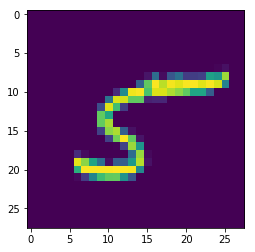

In [3]:
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)
plt.imshow(imgs[1].squeeze())

# Models

Next I'll define the generator and discriminator models for the GAN architecture. These will be simple dense networks with one hidden layer.

<center><img src="https://imgur.com/M8Ev03g.png" width=550px></center>

First I'll define the generator then the discriminator.

### The Generator

The goal of the generator is to take a noise vector and convert it into a 28x28 image. Important things here:

- Leaky ReLU activations on the dense hidden layers. The output of normal ReLUs have a lot of zeros which leads to a lot of zeros in the gradients as well. This tends to make training GANs difficult, so we'll use leaky ReLUs to avoid these sparse gradients
- Tanh on the output layer. The images we generate should have values between -1 and 1.
- Reshape the final output to be the same shape as the real images


In [4]:
class Generator(nn.Module):
    def __init__(self, nz, nhidden):
        super(Generator, self).__init__()

        # input is Z, noise vector, going into a dense layer
        self.fc1 = nn.Linear(nz, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        # Output layer. I'll reshape in forward()
        self.fc3 = nn.Linear(nhidden, 784)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = torch.tanh(self.fc3(x))
        
        # Reshape to (batch-size, color channels, width, height)
        return x.view(-1, 1, 28, 28)

### Discriminator

The discriminator will be a common binary classification network. Again, using leaky ReLUs, but otherwise a normal classifier. The output will be the probability that the input is real.

In [5]:
class Discriminator(nn.Module):
    def __init__(self, nhidden):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, 1)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        
        return x.view(-1, 1)

# Creating functions for displaying images

It's useful to watch the generated images as the networks train so I'm creating a couple functions here to  generate images from the tensors.

In [6]:
def imshow(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().transpose(1, 2, 0)
    plt.imshow(image.squeeze()*2 + 0.5)
    plt.tight_layout()
    plt.axis('off')
    
def image_grid(tensor, figsize = (6,6)):
    """ Display batched images as a grid. Batch size must be a perfect square. """
    bs, c, w, h = tensor.shape
    image_grid = torch.zeros(c, int(w*np.sqrt(bs)), int(h*np.sqrt(bs)))
    for ii, img in enumerate(tensor):
        x = (ii % int(np.sqrt(bs))) * w
        y = (ii // int(np.sqrt(bs))) * h
        image_grid[:, x: x + w, y: y + h] = img
    plt.figure(figsize=figsize)
    plt.tight_layout()
    imshow(image_grid)

# Training the networks

Writing the code for training the networks is surprisingly straightforward. We'll update the networks in three stages:

1. Pass a batch of real images to the discriminator, set the labels to "REAL", calculate the loss, and get the gradients. This improves the discriminator on real images.
2. Pass a batch of fake images to the discriminator, set the labels to "FAKE", calculate the loss, get the gradients, and update the discriminator. This improves the discriminator on fake images.
3. Pass a batch of fake images to the discriminator, set the labels to "REAL", calculate the loss, and update the generator. We want the discriminator to think the fake images are real, so using "REAL" labels will train the generator to make images that the discriminator observes as real.

However, finding the correct hyperparameters can be difficult. Since the generator and discriminator are competing, they need to be balanced so one doesn't dominate the other. The most effective way I've found to balance the models is adjusting the size of the generator and discriminator networks. You can add more hidden units to make wider networks, or add more layers.

### Label smoothing
Stability is improved if the labels for real and fake images are slightly different than 1 and 0, respectively. From what I've seen, most implementations have the label for real images as 0.9 and fake images as 0.

### Setting up things for training

Here I'm going to define some parameters for training, create the models, define the loss, and create the optimizers.

In [7]:
# Use a GPU if one is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0003
batch_size = train_loader.batch_size
beta1 = 0.5   # parameter for Adam optimizer

# Fixed latent noise vectors for observing training progress
nz = 100
fixed_noise = torch.randn(25, nz, device=device)

netG = Generator(nz, 300).to(device)
netD = Discriminator(50).to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Labels we'll use for training, smoothing for the real labels
real_label = 0.9
fake_label = 0

# Training loop

Finally we're at the training loop. You'll want to monitor the training progress to see if the networks are stable and learning together. To do this, I have it printing out a few metrics.

- The discriminator loss, `Loss_D`. If this drops to 0, something is wrong.
- The average prediction probability on real images `D(x)`. Around 0.5 - 0.7 is good.
- The average prediction probability on fake images `D(G(z))`, before and after training the discriminator on fake images. Around 0.3 - 0.5 is good.

I've found it most informative to watch `D(x)` and `D(G(z))`. If the discriminator is really good at detecting real images, `D(x)` will be close to 1 since it's predicting nearly all the real images as real. This means though that it's also really good at detecting fakes and `D(G(z))` will be near 0. In this case the discriminator is too strong. Try making the generator stronger or the discriminator weaker.

If the generator is successfully fooling the discriminator, `D(x)` and `D(G(z))` should be around 0.5 since the discriminator can't tell between the real and fake images. You'll usually find that `D(x)` is a bit larger that 0.5, but as long as the two networks are roughly balanced, the generator will continue to improve.

I've also set it up to generate images after each epoch. This way you can watch the generator get better over time. If the images continue to look like noise, something is wrong. However, sometimes it can take a while before the images look like anything real, so I prefer to watch `D(x)` and `D(G(z))`.

[1/80][0/938] Loss_D: 1.3904 Loss_G: 0.7208 D(x): 0.4787 D(G(z)): 0.4842 / 0.4831
[1/80][200/938] Loss_D: 1.2633 Loss_G: 0.8293 D(x): 0.5247 D(G(z)): 0.4553 / 0.4231
[1/80][400/938] Loss_D: 1.2613 Loss_G: 0.8615 D(x): 0.5230 D(G(z)): 0.4524 / 0.4069
[1/80][600/938] Loss_D: 1.3467 Loss_G: 0.8980 D(x): 0.4837 D(G(z)): 0.4647 / 0.3895
[1/80][800/938] Loss_D: 1.2551 Loss_G: 0.8598 D(x): 0.5010 D(G(z)): 0.4289 / 0.4078


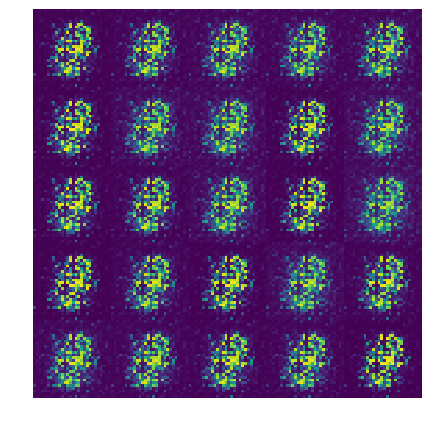

[2/80][62/938] Loss_D: 1.3242 Loss_G: 0.8409 D(x): 0.4730 D(G(z)): 0.4397 / 0.4172
[2/80][262/938] Loss_D: 1.2929 Loss_G: 0.8803 D(x): 0.4805 D(G(z)): 0.4317 / 0.3979
[2/80][462/938] Loss_D: 1.3505 Loss_G: 0.7899 D(x): 0.4746 D(G(z)): 0.4582 / 0.4439
[2/80][662/938] Loss_D: 1.2054 Loss_G: 0.8853 D(x): 0.4929 D(G(z)): 0.3903 / 0.3957
[2/80][862/938] Loss_D: 1.1738 Loss_G: 0.9284 D(x): 0.4672 D(G(z)): 0.3358 / 0.3790


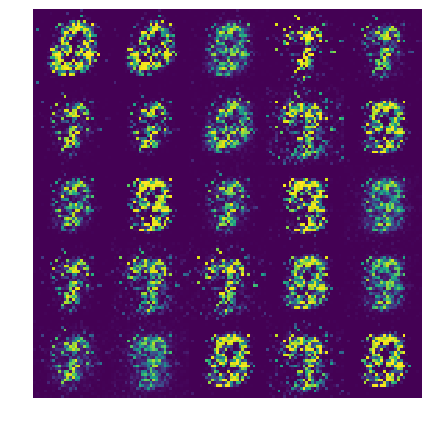

[3/80][124/938] Loss_D: 1.2937 Loss_G: 0.9245 D(x): 0.5395 D(G(z)): 0.4683 / 0.3822
[3/80][324/938] Loss_D: 1.5256 Loss_G: 0.7609 D(x): 0.4236 D(G(z)): 0.4877 / 0.4620
[3/80][524/938] Loss_D: 1.3097 Loss_G: 0.8306 D(x): 0.4922 D(G(z)): 0.4488 / 0.4231
[3/80][724/938] Loss_D: 1.5002 Loss_G: 0.7599 D(x): 0.4101 D(G(z)): 0.4602 / 0.4613
[3/80][924/938] Loss_D: 1.3382 Loss_G: 0.8683 D(x): 0.4580 D(G(z)): 0.4243 / 0.4066


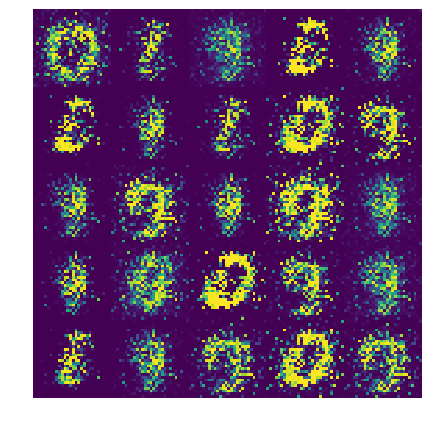

[4/80][186/938] Loss_D: 1.3891 Loss_G: 0.8757 D(x): 0.4767 D(G(z)): 0.4722 / 0.4035
[4/80][386/938] Loss_D: 1.3867 Loss_G: 0.7858 D(x): 0.4400 D(G(z)): 0.4402 / 0.4477
[4/80][586/938] Loss_D: 1.3236 Loss_G: 0.8362 D(x): 0.4886 D(G(z)): 0.4511 / 0.4208
[4/80][786/938] Loss_D: 1.2721 Loss_G: 0.8667 D(x): 0.4721 D(G(z)): 0.4011 / 0.4062


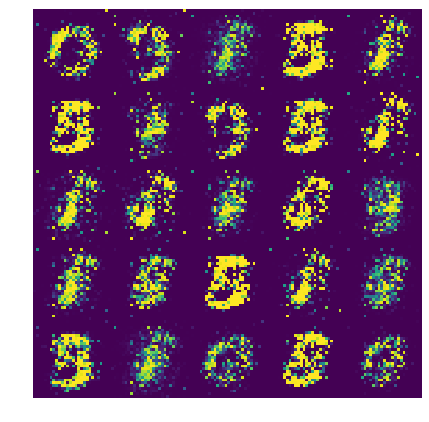

[5/80][48/938] Loss_D: 1.3037 Loss_G: 0.9600 D(x): 0.4915 D(G(z)): 0.4277 / 0.3653
[5/80][248/938] Loss_D: 1.1908 Loss_G: 0.8927 D(x): 0.4507 D(G(z)): 0.2970 / 0.3993
[5/80][448/938] Loss_D: 1.5045 Loss_G: 0.8894 D(x): 0.4444 D(G(z)): 0.4977 / 0.3972
[5/80][648/938] Loss_D: 1.2905 Loss_G: 0.8506 D(x): 0.4537 D(G(z)): 0.3947 / 0.4155
[5/80][848/938] Loss_D: 1.3199 Loss_G: 0.8251 D(x): 0.4577 D(G(z)): 0.4155 / 0.4289


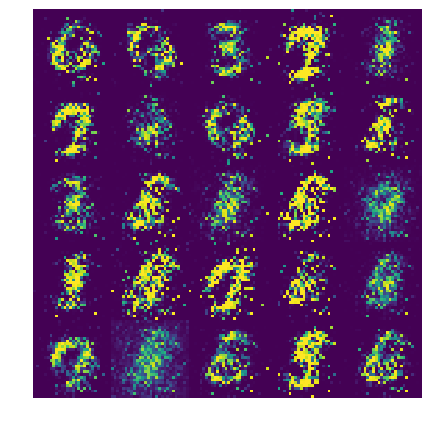

[6/80][110/938] Loss_D: 1.3056 Loss_G: 0.8369 D(x): 0.4557 D(G(z)): 0.4065 / 0.4209
[6/80][310/938] Loss_D: 1.3863 Loss_G: 0.7922 D(x): 0.4629 D(G(z)): 0.4591 / 0.4440
[6/80][510/938] Loss_D: 1.4139 Loss_G: 0.8185 D(x): 0.4349 D(G(z)): 0.4375 / 0.4318
[6/80][710/938] Loss_D: 1.2379 Loss_G: 0.8740 D(x): 0.5051 D(G(z)): 0.4125 / 0.4041
[6/80][910/938] Loss_D: 1.3456 Loss_G: 0.7882 D(x): 0.4084 D(G(z)): 0.3635 / 0.4537


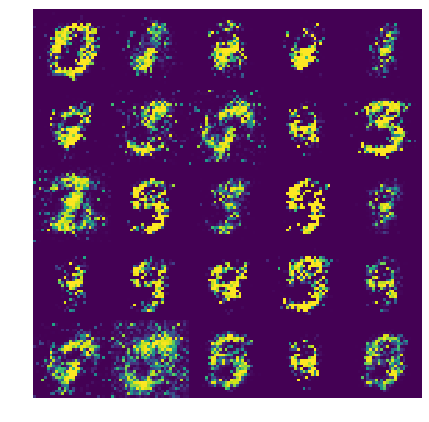

[7/80][172/938] Loss_D: 1.3378 Loss_G: 0.8241 D(x): 0.4127 D(G(z)): 0.3722 / 0.4284
[7/80][372/938] Loss_D: 1.3001 Loss_G: 0.8492 D(x): 0.4954 D(G(z)): 0.4409 / 0.4165
[7/80][572/938] Loss_D: 1.3494 Loss_G: 0.8279 D(x): 0.4539 D(G(z)): 0.4206 / 0.4305
[7/80][772/938] Loss_D: 1.3142 Loss_G: 0.8428 D(x): 0.4690 D(G(z)): 0.4246 / 0.4176


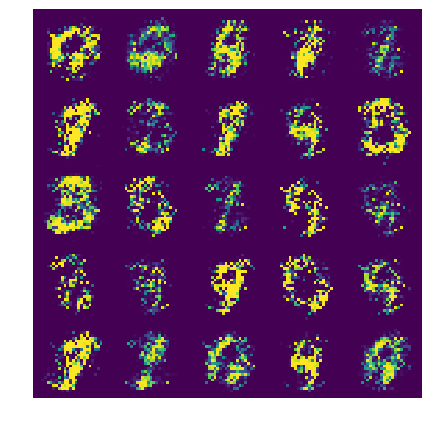

[8/80][34/938] Loss_D: 1.3569 Loss_G: 0.8372 D(x): 0.4434 D(G(z)): 0.4288 / 0.4203
[8/80][234/938] Loss_D: 1.3716 Loss_G: 0.8127 D(x): 0.4475 D(G(z)): 0.4367 / 0.4342
[8/80][434/938] Loss_D: 1.3690 Loss_G: 0.8006 D(x): 0.4481 D(G(z)): 0.4395 / 0.4399
[8/80][634/938] Loss_D: 1.4161 Loss_G: 0.9683 D(x): 0.5019 D(G(z)): 0.4980 / 0.3661
[8/80][834/938] Loss_D: 1.2403 Loss_G: 0.9510 D(x): 0.5087 D(G(z)): 0.4208 / 0.3689


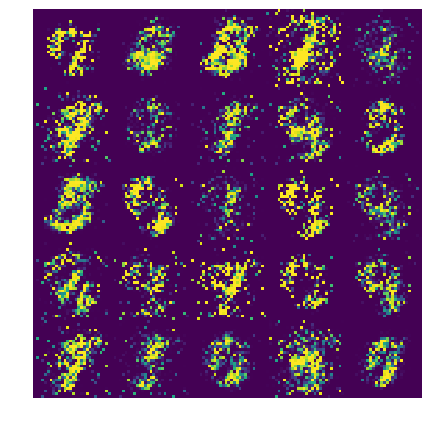

[9/80][96/938] Loss_D: 1.3223 Loss_G: 0.8972 D(x): 0.4604 D(G(z)): 0.4094 / 0.3945
[9/80][296/938] Loss_D: 1.4350 Loss_G: 0.7602 D(x): 0.4498 D(G(z)): 0.4700 / 0.4632
[9/80][496/938] Loss_D: 1.3339 Loss_G: 0.8331 D(x): 0.4747 D(G(z)): 0.4303 / 0.4269
[9/80][696/938] Loss_D: 1.3602 Loss_G: 0.8456 D(x): 0.4627 D(G(z)): 0.4469 / 0.4168
[9/80][896/938] Loss_D: 1.3585 Loss_G: 0.8284 D(x): 0.4572 D(G(z)): 0.4317 / 0.4258


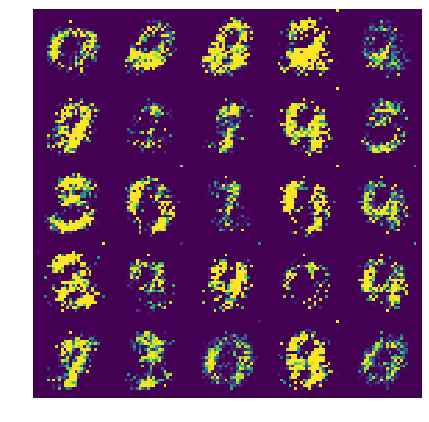

[10/80][158/938] Loss_D: 1.3354 Loss_G: 0.8415 D(x): 0.4952 D(G(z)): 0.4490 / 0.4198
[10/80][358/938] Loss_D: 1.3200 Loss_G: 0.8443 D(x): 0.5095 D(G(z)): 0.4558 / 0.4176
[10/80][558/938] Loss_D: 1.2677 Loss_G: 0.9214 D(x): 0.4905 D(G(z)): 0.4056 / 0.3812
[10/80][758/938] Loss_D: 1.4044 Loss_G: 0.8847 D(x): 0.4620 D(G(z)): 0.4440 / 0.4056


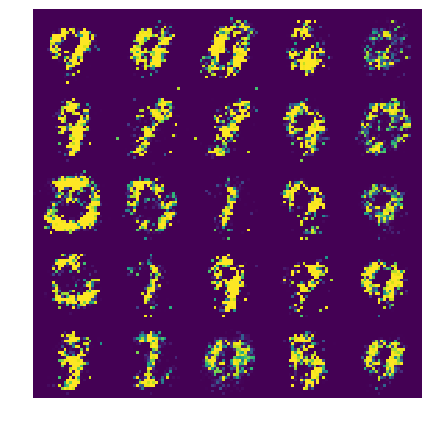

[11/80][20/938] Loss_D: 1.3156 Loss_G: 0.8822 D(x): 0.4717 D(G(z)): 0.4185 / 0.4045
[11/80][220/938] Loss_D: 1.2986 Loss_G: 0.9315 D(x): 0.4740 D(G(z)): 0.4067 / 0.3823
[11/80][420/938] Loss_D: 1.3310 Loss_G: 0.8721 D(x): 0.4486 D(G(z)): 0.4027 / 0.4073
[11/80][620/938] Loss_D: 1.2832 Loss_G: 0.8888 D(x): 0.4577 D(G(z)): 0.3871 / 0.3963
[11/80][820/938] Loss_D: 1.2848 Loss_G: 0.8873 D(x): 0.5142 D(G(z)): 0.4461 / 0.3986


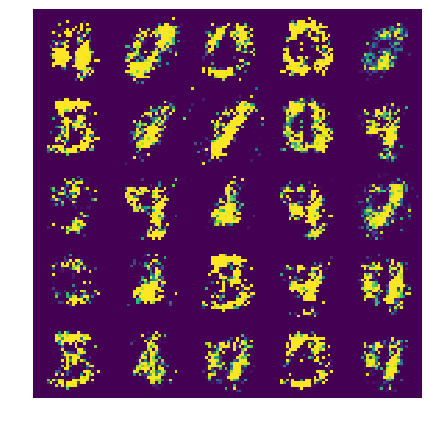

[12/80][82/938] Loss_D: 1.2643 Loss_G: 0.8184 D(x): 0.4700 D(G(z)): 0.3892 / 0.4338
[12/80][282/938] Loss_D: 1.3199 Loss_G: 0.8342 D(x): 0.4620 D(G(z)): 0.4049 / 0.4265
[12/80][482/938] Loss_D: 1.2417 Loss_G: 0.9996 D(x): 0.4924 D(G(z)): 0.3657 / 0.3597
[12/80][682/938] Loss_D: 1.2421 Loss_G: 1.0091 D(x): 0.5397 D(G(z)): 0.4053 / 0.3584
[12/80][882/938] Loss_D: 1.1586 Loss_G: 1.1023 D(x): 0.5491 D(G(z)): 0.3577 / 0.3271


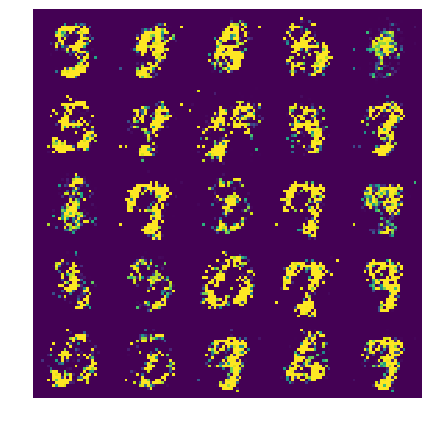

[13/80][144/938] Loss_D: 1.1634 Loss_G: 1.0756 D(x): 0.5506 D(G(z)): 0.3578 / 0.3340
[13/80][344/938] Loss_D: 1.2068 Loss_G: 0.9579 D(x): 0.4978 D(G(z)): 0.3601 / 0.3722
[13/80][544/938] Loss_D: 1.2449 Loss_G: 0.9274 D(x): 0.4710 D(G(z)): 0.3550 / 0.3814
[13/80][744/938] Loss_D: 1.3413 Loss_G: 0.9203 D(x): 0.4561 D(G(z)): 0.3931 / 0.3953


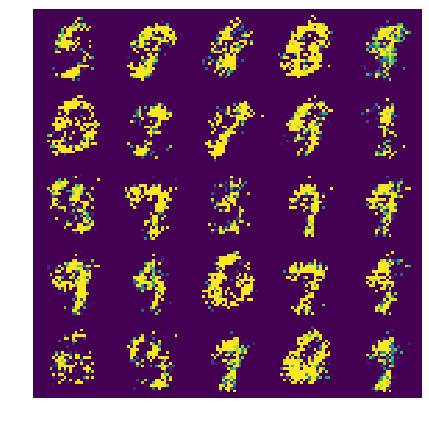

[14/80][6/938] Loss_D: 1.2319 Loss_G: 0.9454 D(x): 0.5513 D(G(z)): 0.4335 / 0.3739
[14/80][206/938] Loss_D: 1.2248 Loss_G: 0.9609 D(x): 0.4849 D(G(z)): 0.3554 / 0.3717
[14/80][406/938] Loss_D: 1.2465 Loss_G: 1.0554 D(x): 0.4774 D(G(z)): 0.3332 / 0.3362
[14/80][606/938] Loss_D: 1.1127 Loss_G: 1.0897 D(x): 0.5244 D(G(z)): 0.3288 / 0.3270
[14/80][806/938] Loss_D: 1.2598 Loss_G: 1.0136 D(x): 0.5222 D(G(z)): 0.3903 / 0.3615


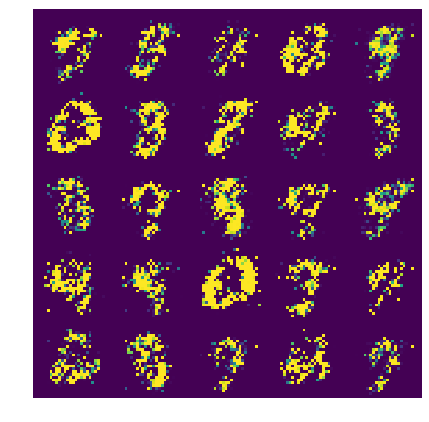

[15/80][68/938] Loss_D: 1.1833 Loss_G: 1.1098 D(x): 0.5310 D(G(z)): 0.3645 / 0.3192
[15/80][268/938] Loss_D: 1.1280 Loss_G: 1.3690 D(x): 0.6484 D(G(z)): 0.4089 / 0.2409
[15/80][468/938] Loss_D: 1.1948 Loss_G: 1.1651 D(x): 0.5466 D(G(z)): 0.3864 / 0.3026
[15/80][668/938] Loss_D: 1.2124 Loss_G: 1.0198 D(x): 0.4456 D(G(z)): 0.2347 / 0.3524
[15/80][868/938] Loss_D: 1.1383 Loss_G: 1.0660 D(x): 0.5336 D(G(z)): 0.3112 / 0.3304


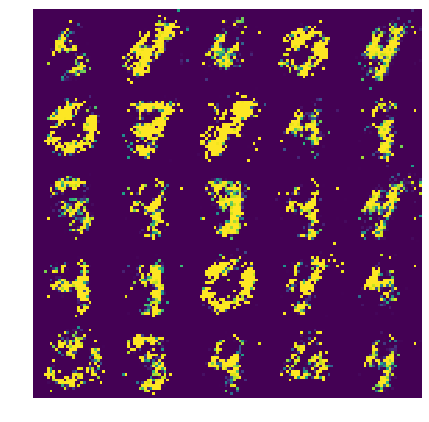

[16/80][130/938] Loss_D: 1.3021 Loss_G: 0.8937 D(x): 0.4918 D(G(z)): 0.4080 / 0.4015
[16/80][330/938] Loss_D: 1.2623 Loss_G: 0.9353 D(x): 0.4743 D(G(z)): 0.3630 / 0.3911
[16/80][530/938] Loss_D: 1.3842 Loss_G: 0.9165 D(x): 0.4405 D(G(z)): 0.3851 / 0.3960
[16/80][730/938] Loss_D: 1.2628 Loss_G: 1.0025 D(x): 0.5056 D(G(z)): 0.3871 / 0.3592
[16/80][930/938] Loss_D: 1.2517 Loss_G: 0.8877 D(x): 0.5010 D(G(z)): 0.3835 / 0.4078


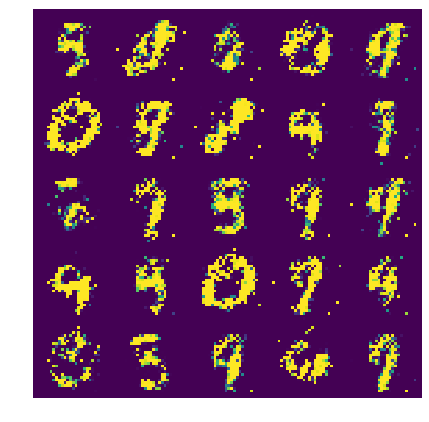

[17/80][192/938] Loss_D: 1.2737 Loss_G: 0.9714 D(x): 0.5133 D(G(z)): 0.3885 / 0.3725
[17/80][392/938] Loss_D: 1.2218 Loss_G: 0.9579 D(x): 0.5508 D(G(z)): 0.3930 / 0.3702
[17/80][592/938] Loss_D: 1.2492 Loss_G: 1.2748 D(x): 0.6179 D(G(z)): 0.4799 / 0.2595
[17/80][792/938] Loss_D: 1.3222 Loss_G: 0.8300 D(x): 0.4768 D(G(z)): 0.4132 / 0.4312


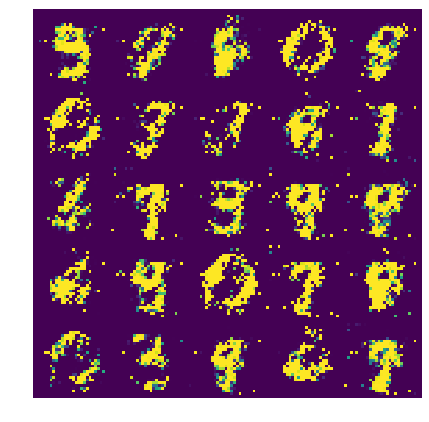

[18/80][54/938] Loss_D: 1.2503 Loss_G: 0.8456 D(x): 0.4464 D(G(z)): 0.3091 / 0.4262
[18/80][254/938] Loss_D: 1.2699 Loss_G: 0.9014 D(x): 0.5172 D(G(z)): 0.3915 / 0.4024
[18/80][454/938] Loss_D: 1.1506 Loss_G: 1.0298 D(x): 0.5317 D(G(z)): 0.3447 / 0.3478
[18/80][654/938] Loss_D: 1.3202 Loss_G: 0.9726 D(x): 0.4700 D(G(z)): 0.3579 / 0.3801
[18/80][854/938] Loss_D: 1.1661 Loss_G: 1.0708 D(x): 0.5157 D(G(z)): 0.3144 / 0.3323


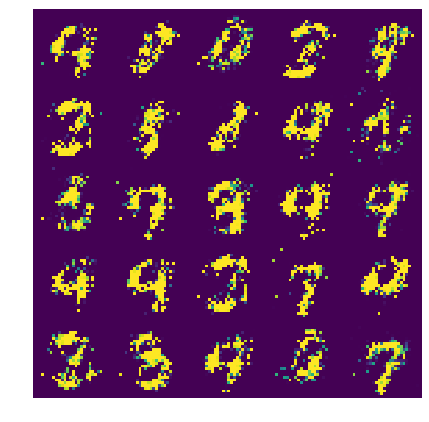

[19/80][116/938] Loss_D: 1.3268 Loss_G: 0.9742 D(x): 0.4272 D(G(z)): 0.3249 / 0.3772
[19/80][316/938] Loss_D: 1.3031 Loss_G: 1.0671 D(x): 0.5604 D(G(z)): 0.4568 / 0.3302
[19/80][516/938] Loss_D: 1.2553 Loss_G: 1.1918 D(x): 0.5594 D(G(z)): 0.4035 / 0.2933
[19/80][716/938] Loss_D: 1.2141 Loss_G: 1.1054 D(x): 0.5701 D(G(z)): 0.3977 / 0.3263
[19/80][916/938] Loss_D: 1.2786 Loss_G: 0.9498 D(x): 0.5291 D(G(z)): 0.4124 / 0.3842


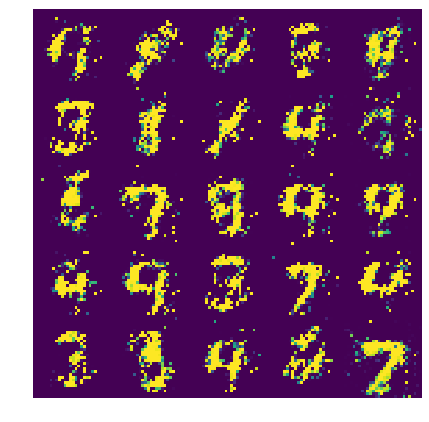

[20/80][178/938] Loss_D: 1.2194 Loss_G: 1.0894 D(x): 0.6098 D(G(z)): 0.4395 / 0.3253
[20/80][378/938] Loss_D: 1.3318 Loss_G: 0.9151 D(x): 0.4822 D(G(z)): 0.3896 / 0.3940
[20/80][578/938] Loss_D: 1.2051 Loss_G: 1.2537 D(x): 0.5878 D(G(z)): 0.3991 / 0.2792
[20/80][778/938] Loss_D: 1.2628 Loss_G: 0.9417 D(x): 0.5820 D(G(z)): 0.4447 / 0.3875


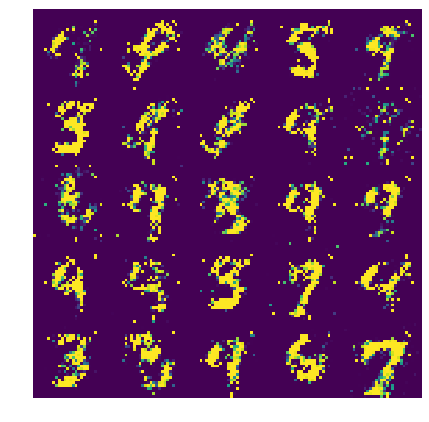

[21/80][40/938] Loss_D: 1.2595 Loss_G: 0.9240 D(x): 0.4977 D(G(z)): 0.3680 / 0.3906
[21/80][240/938] Loss_D: 1.3281 Loss_G: 0.9074 D(x): 0.4535 D(G(z)): 0.3745 / 0.4013
[21/80][440/938] Loss_D: 1.2591 Loss_G: 0.9679 D(x): 0.5084 D(G(z)): 0.3883 / 0.3746
[21/80][640/938] Loss_D: 1.2374 Loss_G: 1.0365 D(x): 0.5679 D(G(z)): 0.4491 / 0.3388
[21/80][840/938] Loss_D: 1.3512 Loss_G: 0.8321 D(x): 0.4473 D(G(z)): 0.3997 / 0.4280


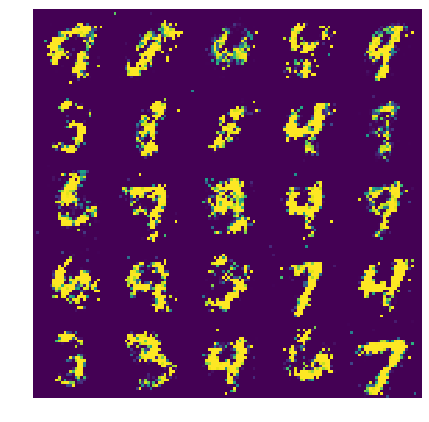

[22/80][102/938] Loss_D: 1.2687 Loss_G: 0.9654 D(x): 0.5453 D(G(z)): 0.4476 / 0.3688
[22/80][302/938] Loss_D: 1.3515 Loss_G: 0.8826 D(x): 0.4684 D(G(z)): 0.4068 / 0.4074
[22/80][502/938] Loss_D: 1.3399 Loss_G: 1.0064 D(x): 0.5414 D(G(z)): 0.4650 / 0.3601
[22/80][702/938] Loss_D: 1.2484 Loss_G: 0.9055 D(x): 0.5272 D(G(z)): 0.4214 / 0.3966
[22/80][902/938] Loss_D: 1.2995 Loss_G: 0.8427 D(x): 0.4966 D(G(z)): 0.4114 / 0.4247


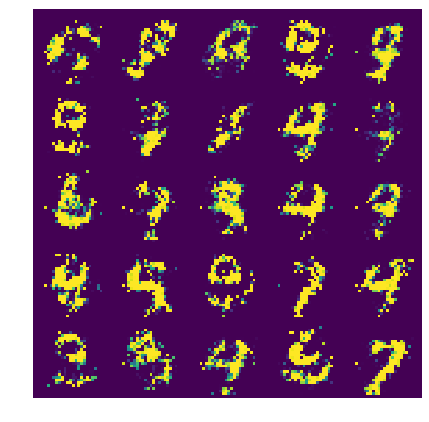

[23/80][164/938] Loss_D: 1.1751 Loss_G: 0.9452 D(x): 0.4989 D(G(z)): 0.3432 / 0.3788
[23/80][364/938] Loss_D: 1.3156 Loss_G: 0.8007 D(x): 0.4935 D(G(z)): 0.4272 / 0.4491
[23/80][564/938] Loss_D: 1.2265 Loss_G: 1.0599 D(x): 0.4955 D(G(z)): 0.3812 / 0.3335
[23/80][764/938] Loss_D: 1.2757 Loss_G: 1.0033 D(x): 0.5073 D(G(z)): 0.4107 / 0.3533


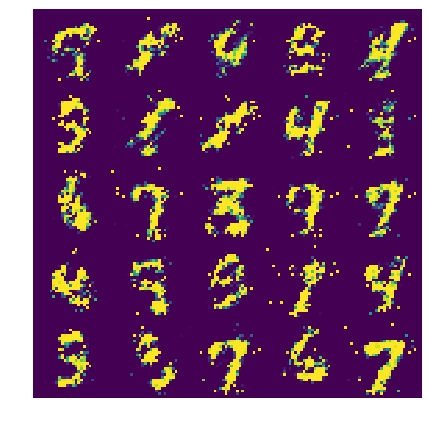

[24/80][26/938] Loss_D: 1.2481 Loss_G: 0.9202 D(x): 0.4930 D(G(z)): 0.3908 / 0.3931
[24/80][226/938] Loss_D: 1.3068 Loss_G: 0.9192 D(x): 0.5179 D(G(z)): 0.4425 / 0.3938
[24/80][426/938] Loss_D: 1.2334 Loss_G: 0.9705 D(x): 0.5150 D(G(z)): 0.3912 / 0.3706
[24/80][626/938] Loss_D: 1.2726 Loss_G: 0.9141 D(x): 0.5679 D(G(z)): 0.4629 / 0.3982
[24/80][826/938] Loss_D: 1.2077 Loss_G: 1.0302 D(x): 0.5429 D(G(z)): 0.3922 / 0.3517


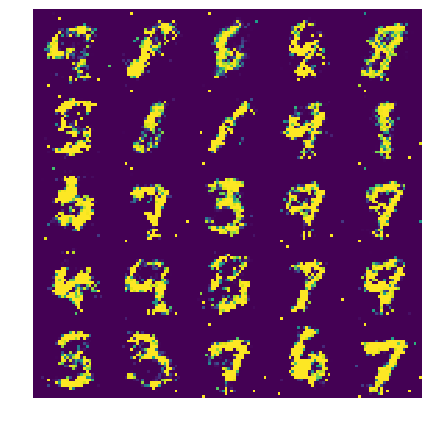

[25/80][88/938] Loss_D: 1.2088 Loss_G: 0.9459 D(x): 0.5034 D(G(z)): 0.3527 / 0.3875
[25/80][288/938] Loss_D: 1.2115 Loss_G: 0.9129 D(x): 0.5091 D(G(z)): 0.3781 / 0.3920
[25/80][488/938] Loss_D: 1.2469 Loss_G: 1.0113 D(x): 0.5323 D(G(z)): 0.4184 / 0.3529
[25/80][688/938] Loss_D: 1.2099 Loss_G: 1.0055 D(x): 0.4927 D(G(z)): 0.3434 / 0.3591
[25/80][888/938] Loss_D: 1.2830 Loss_G: 0.9721 D(x): 0.4824 D(G(z)): 0.3913 / 0.3734


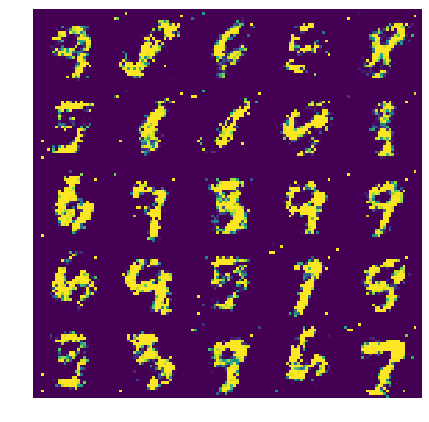

[26/80][150/938] Loss_D: 1.2565 Loss_G: 0.9805 D(x): 0.5372 D(G(z)): 0.4274 / 0.3646
[26/80][350/938] Loss_D: 1.2236 Loss_G: 1.0192 D(x): 0.4488 D(G(z)): 0.3151 / 0.3495
[26/80][550/938] Loss_D: 1.1890 Loss_G: 0.9609 D(x): 0.5070 D(G(z)): 0.3505 / 0.3823
[26/80][750/938] Loss_D: 1.2556 Loss_G: 0.9315 D(x): 0.5458 D(G(z)): 0.4249 / 0.3859


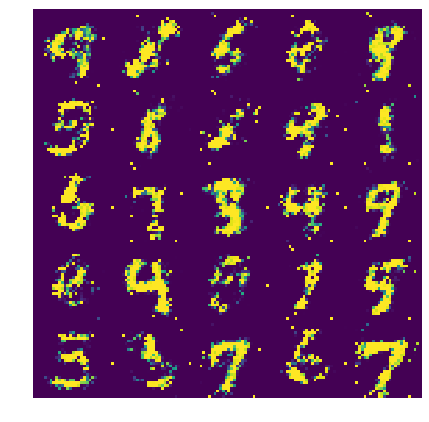

[27/80][12/938] Loss_D: 1.1346 Loss_G: 0.9813 D(x): 0.5359 D(G(z)): 0.3488 / 0.3682
[27/80][212/938] Loss_D: 1.4015 Loss_G: 0.8277 D(x): 0.4537 D(G(z)): 0.4148 / 0.4488
[27/80][412/938] Loss_D: 1.2307 Loss_G: 0.9516 D(x): 0.5583 D(G(z)): 0.4214 / 0.3850
[27/80][612/938] Loss_D: 1.2295 Loss_G: 1.0196 D(x): 0.5166 D(G(z)): 0.3816 / 0.3516
[27/80][812/938] Loss_D: 1.2823 Loss_G: 0.9766 D(x): 0.5146 D(G(z)): 0.4189 / 0.3678


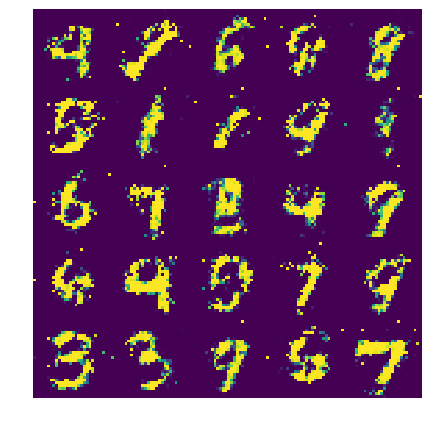

[28/80][74/938] Loss_D: 1.3293 Loss_G: 0.8852 D(x): 0.4334 D(G(z)): 0.3440 / 0.4119
[28/80][274/938] Loss_D: 1.2409 Loss_G: 0.9586 D(x): 0.4919 D(G(z)): 0.3631 / 0.3796
[28/80][474/938] Loss_D: 1.3230 Loss_G: 0.9014 D(x): 0.4320 D(G(z)): 0.3694 / 0.4035
[28/80][674/938] Loss_D: 1.2695 Loss_G: 0.8361 D(x): 0.4583 D(G(z)): 0.3494 / 0.4401
[28/80][874/938] Loss_D: 1.1999 Loss_G: 1.0311 D(x): 0.5322 D(G(z)): 0.3888 / 0.3499


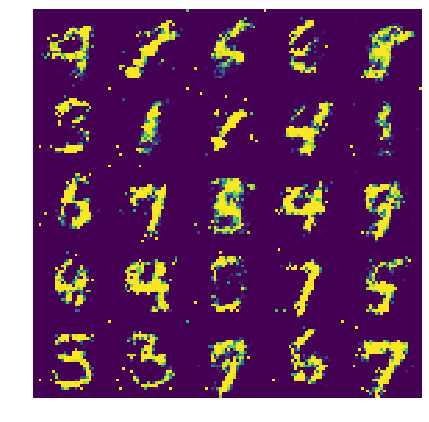

[29/80][136/938] Loss_D: 1.2880 Loss_G: 1.0453 D(x): 0.4441 D(G(z)): 0.3257 / 0.3476
[29/80][336/938] Loss_D: 1.2231 Loss_G: 1.0183 D(x): 0.5188 D(G(z)): 0.3891 / 0.3560
[29/80][536/938] Loss_D: 1.3179 Loss_G: 0.9367 D(x): 0.4715 D(G(z)): 0.3904 / 0.3891
[29/80][736/938] Loss_D: 1.2715 Loss_G: 1.0228 D(x): 0.4919 D(G(z)): 0.3758 / 0.3581
[29/80][936/938] Loss_D: 1.3103 Loss_G: 0.8587 D(x): 0.4647 D(G(z)): 0.3888 / 0.4205


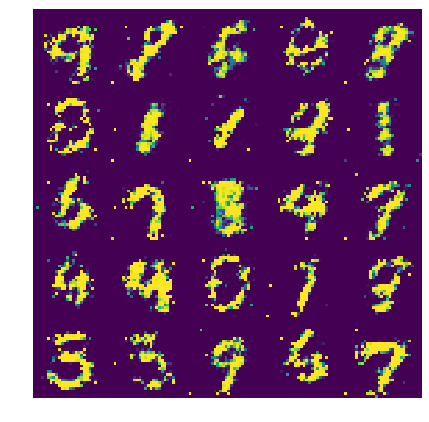

[30/80][198/938] Loss_D: 1.1385 Loss_G: 1.0156 D(x): 0.5690 D(G(z)): 0.3631 / 0.3605
[30/80][398/938] Loss_D: 1.1771 Loss_G: 1.0444 D(x): 0.5500 D(G(z)): 0.3927 / 0.3499
[30/80][598/938] Loss_D: 1.2451 Loss_G: 1.0223 D(x): 0.5192 D(G(z)): 0.3844 / 0.3645
[30/80][798/938] Loss_D: 1.2829 Loss_G: 0.9461 D(x): 0.4919 D(G(z)): 0.3664 / 0.3956


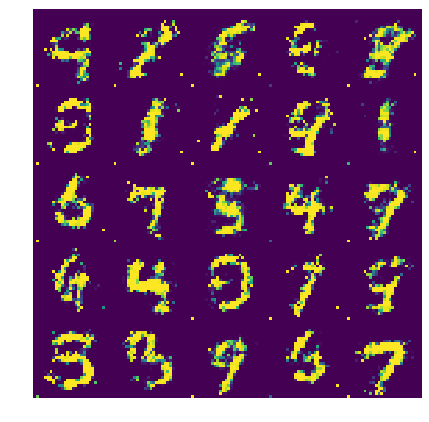

[31/80][60/938] Loss_D: 1.1854 Loss_G: 1.0540 D(x): 0.5937 D(G(z)): 0.4267 / 0.3418
[31/80][260/938] Loss_D: 1.2272 Loss_G: 0.9174 D(x): 0.5290 D(G(z)): 0.3917 / 0.4031
[31/80][460/938] Loss_D: 1.2836 Loss_G: 0.8953 D(x): 0.5035 D(G(z)): 0.3971 / 0.4165
[31/80][660/938] Loss_D: 1.3082 Loss_G: 1.0792 D(x): 0.4768 D(G(z)): 0.3678 / 0.3386
[31/80][860/938] Loss_D: 1.3104 Loss_G: 0.9763 D(x): 0.4803 D(G(z)): 0.3923 / 0.3781


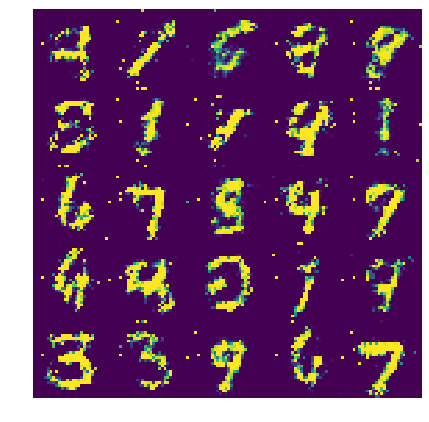

[32/80][122/938] Loss_D: 1.2418 Loss_G: 1.0254 D(x): 0.5489 D(G(z)): 0.4177 / 0.3586
[32/80][322/938] Loss_D: 1.2266 Loss_G: 0.9799 D(x): 0.4679 D(G(z)): 0.3261 / 0.3785
[32/80][522/938] Loss_D: 1.2069 Loss_G: 1.1638 D(x): 0.5039 D(G(z)): 0.3493 / 0.3100
[32/80][722/938] Loss_D: 1.1362 Loss_G: 1.1341 D(x): 0.5509 D(G(z)): 0.3562 / 0.3177
[32/80][922/938] Loss_D: 1.2375 Loss_G: 1.0703 D(x): 0.5487 D(G(z)): 0.3997 / 0.3473


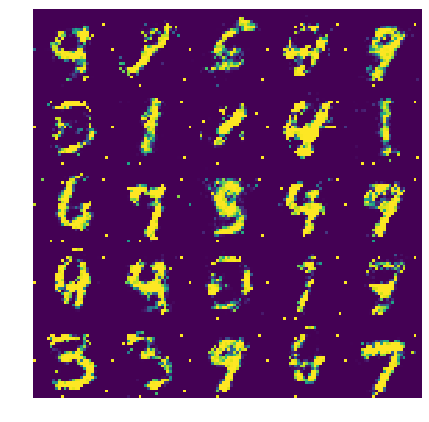

[33/80][184/938] Loss_D: 1.2643 Loss_G: 1.0520 D(x): 0.5016 D(G(z)): 0.3739 / 0.3569
[33/80][384/938] Loss_D: 1.2227 Loss_G: 1.1042 D(x): 0.4826 D(G(z)): 0.3106 / 0.3350
[33/80][584/938] Loss_D: 1.2291 Loss_G: 0.9621 D(x): 0.5164 D(G(z)): 0.3810 / 0.3848
[33/80][784/938] Loss_D: 1.1694 Loss_G: 1.1169 D(x): 0.5784 D(G(z)): 0.4044 / 0.3239


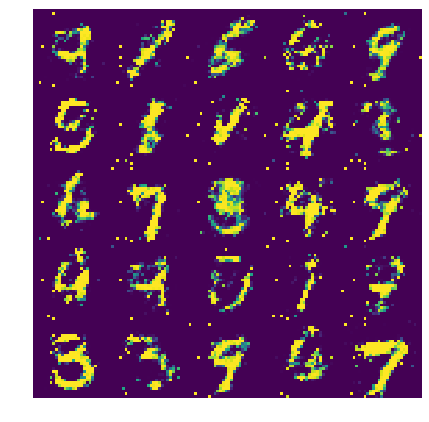

[34/80][46/938] Loss_D: 1.1767 Loss_G: 0.9535 D(x): 0.5081 D(G(z)): 0.3430 / 0.3889
[34/80][246/938] Loss_D: 1.1792 Loss_G: 1.0960 D(x): 0.5255 D(G(z)): 0.3631 / 0.3388
[34/80][446/938] Loss_D: 1.2215 Loss_G: 1.0499 D(x): 0.5111 D(G(z)): 0.3513 / 0.3623
[34/80][646/938] Loss_D: 1.2145 Loss_G: 1.0353 D(x): 0.5471 D(G(z)): 0.3656 / 0.3542
[34/80][846/938] Loss_D: 1.1416 Loss_G: 1.1690 D(x): 0.5931 D(G(z)): 0.3967 / 0.3031


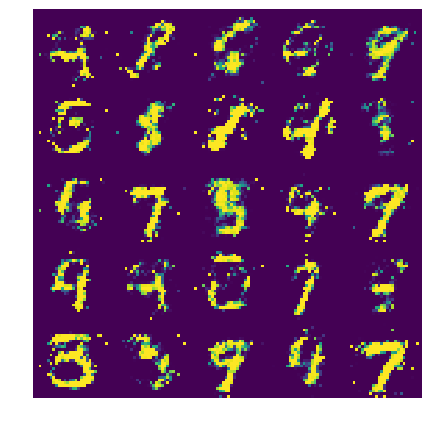

[35/80][108/938] Loss_D: 1.2185 Loss_G: 1.0363 D(x): 0.5773 D(G(z)): 0.4261 / 0.3526
[35/80][308/938] Loss_D: 1.2884 Loss_G: 1.0353 D(x): 0.5545 D(G(z)): 0.4381 / 0.3483
[35/80][508/938] Loss_D: 1.1756 Loss_G: 1.2008 D(x): 0.5502 D(G(z)): 0.3795 / 0.2950
[35/80][708/938] Loss_D: 1.2333 Loss_G: 0.9916 D(x): 0.4798 D(G(z)): 0.3436 / 0.3710
[35/80][908/938] Loss_D: 1.2578 Loss_G: 0.9349 D(x): 0.5111 D(G(z)): 0.3864 / 0.3940


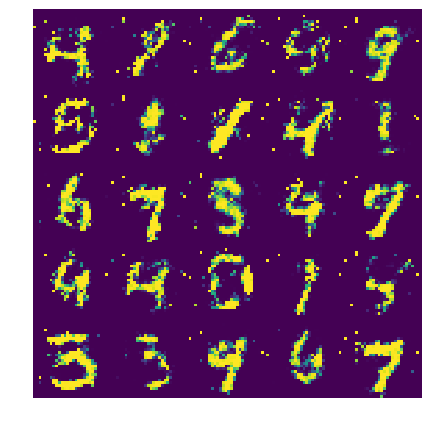

[36/80][170/938] Loss_D: 1.3203 Loss_G: 0.9903 D(x): 0.4904 D(G(z)): 0.4039 / 0.3751
[36/80][370/938] Loss_D: 1.1980 Loss_G: 1.0115 D(x): 0.5280 D(G(z)): 0.3683 / 0.3656
[36/80][570/938] Loss_D: 1.2103 Loss_G: 1.0622 D(x): 0.5492 D(G(z)): 0.4042 / 0.3445
[36/80][770/938] Loss_D: 1.3171 Loss_G: 0.9578 D(x): 0.5065 D(G(z)): 0.4050 / 0.3897


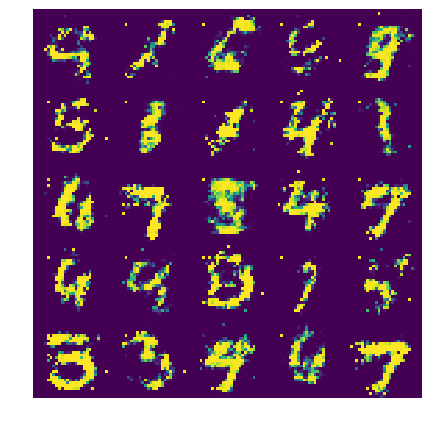

[37/80][32/938] Loss_D: 1.2144 Loss_G: 1.0485 D(x): 0.5383 D(G(z)): 0.3855 / 0.3550
[37/80][232/938] Loss_D: 1.2395 Loss_G: 0.9456 D(x): 0.4762 D(G(z)): 0.3388 / 0.3922
[37/80][432/938] Loss_D: 1.2979 Loss_G: 1.0802 D(x): 0.4881 D(G(z)): 0.3785 / 0.3411
[37/80][632/938] Loss_D: 1.2674 Loss_G: 1.1112 D(x): 0.5752 D(G(z)): 0.4470 / 0.3282
[37/80][832/938] Loss_D: 1.2203 Loss_G: 0.9829 D(x): 0.5227 D(G(z)): 0.3839 / 0.3760


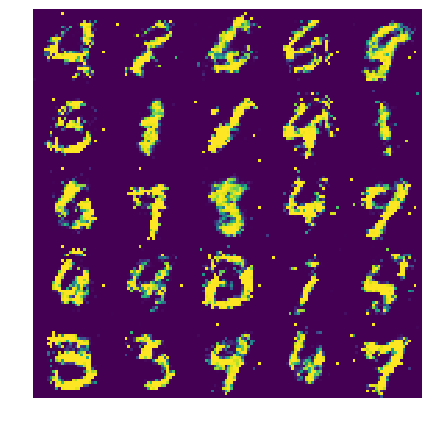

[38/80][94/938] Loss_D: 1.2400 Loss_G: 1.0397 D(x): 0.5472 D(G(z)): 0.4024 / 0.3534
[38/80][294/938] Loss_D: 1.3138 Loss_G: 1.0287 D(x): 0.4874 D(G(z)): 0.3613 / 0.3644
[38/80][494/938] Loss_D: 1.2447 Loss_G: 1.0219 D(x): 0.4954 D(G(z)): 0.3629 / 0.3677
[38/80][694/938] Loss_D: 1.1380 Loss_G: 1.1392 D(x): 0.5623 D(G(z)): 0.3710 / 0.3151
[38/80][894/938] Loss_D: 1.2829 Loss_G: 0.9557 D(x): 0.5235 D(G(z)): 0.4246 / 0.3881


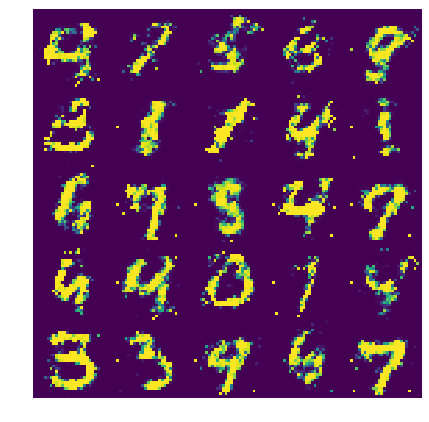

[39/80][156/938] Loss_D: 1.2481 Loss_G: 1.0050 D(x): 0.5593 D(G(z)): 0.4378 / 0.3640
[39/80][356/938] Loss_D: 1.1922 Loss_G: 1.0889 D(x): 0.5774 D(G(z)): 0.4088 / 0.3305
[39/80][556/938] Loss_D: 1.2346 Loss_G: 0.9165 D(x): 0.4570 D(G(z)): 0.3262 / 0.4002
[39/80][756/938] Loss_D: 1.1609 Loss_G: 1.2177 D(x): 0.6083 D(G(z)): 0.4022 / 0.2950


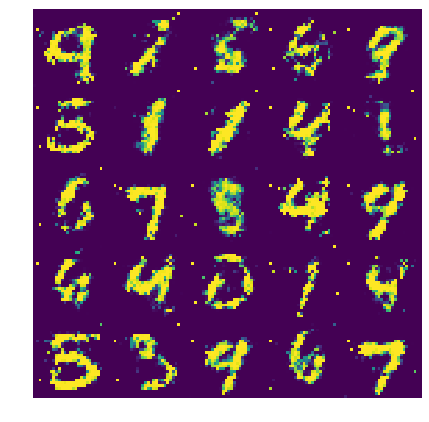

[40/80][18/938] Loss_D: 1.1226 Loss_G: 1.1741 D(x): 0.4929 D(G(z)): 0.3063 / 0.3063
[40/80][218/938] Loss_D: 1.1815 Loss_G: 0.9723 D(x): 0.5337 D(G(z)): 0.3717 / 0.3815
[40/80][418/938] Loss_D: 1.2498 Loss_G: 1.0240 D(x): 0.5256 D(G(z)): 0.3786 / 0.3610
[40/80][618/938] Loss_D: 1.2649 Loss_G: 1.0088 D(x): 0.5099 D(G(z)): 0.3819 / 0.3675
[40/80][818/938] Loss_D: 1.2304 Loss_G: 0.9660 D(x): 0.5452 D(G(z)): 0.4205 / 0.3825


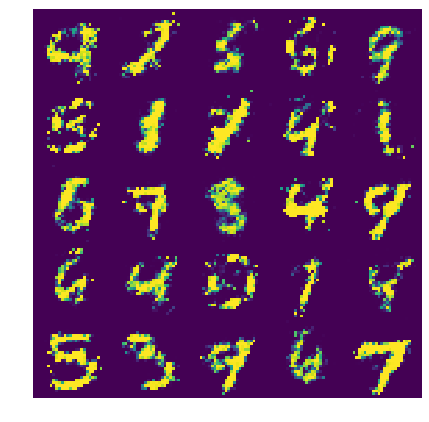

[41/80][80/938] Loss_D: 1.2785 Loss_G: 0.9306 D(x): 0.4780 D(G(z)): 0.3638 / 0.4024
[41/80][280/938] Loss_D: 1.2383 Loss_G: 0.9499 D(x): 0.4928 D(G(z)): 0.3600 / 0.3855
[41/80][480/938] Loss_D: 1.2043 Loss_G: 0.9824 D(x): 0.5422 D(G(z)): 0.3992 / 0.3733
[41/80][680/938] Loss_D: 1.3048 Loss_G: 0.9443 D(x): 0.4651 D(G(z)): 0.3688 / 0.3993
[41/80][880/938] Loss_D: 1.3400 Loss_G: 0.9267 D(x): 0.5021 D(G(z)): 0.4313 / 0.3990


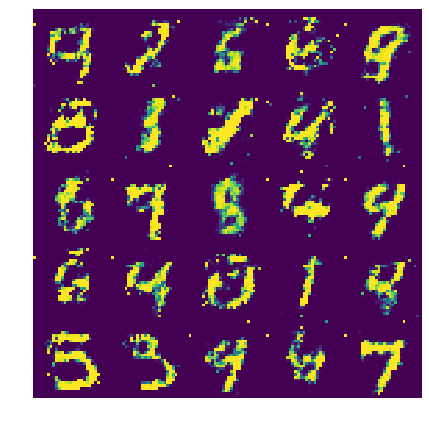

[42/80][142/938] Loss_D: 1.2516 Loss_G: 1.0345 D(x): 0.5419 D(G(z)): 0.4017 / 0.3538
[42/80][342/938] Loss_D: 1.3871 Loss_G: 0.9790 D(x): 0.4944 D(G(z)): 0.4309 / 0.3980
[42/80][542/938] Loss_D: 1.3145 Loss_G: 0.9914 D(x): 0.4962 D(G(z)): 0.4084 / 0.3773
[42/80][742/938] Loss_D: 1.3012 Loss_G: 1.0018 D(x): 0.4699 D(G(z)): 0.3780 / 0.3678


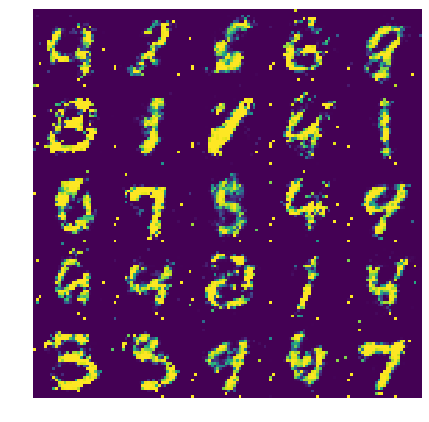

[43/80][4/938] Loss_D: 1.2659 Loss_G: 0.9177 D(x): 0.5151 D(G(z)): 0.4000 / 0.4015
[43/80][204/938] Loss_D: 1.1923 Loss_G: 1.1269 D(x): 0.5285 D(G(z)): 0.3581 / 0.3171
[43/80][404/938] Loss_D: 1.2263 Loss_G: 1.0117 D(x): 0.5019 D(G(z)): 0.3657 / 0.3630
[43/80][604/938] Loss_D: 1.1557 Loss_G: 1.0414 D(x): 0.4859 D(G(z)): 0.3050 / 0.3559
[43/80][804/938] Loss_D: 1.1744 Loss_G: 1.0051 D(x): 0.5379 D(G(z)): 0.3831 / 0.3704


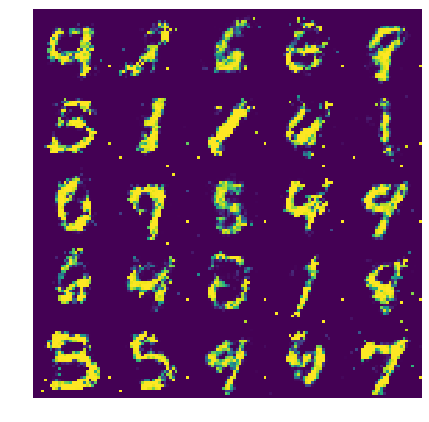

[44/80][66/938] Loss_D: 1.2712 Loss_G: 0.9225 D(x): 0.4783 D(G(z)): 0.3735 / 0.4032
[44/80][266/938] Loss_D: 1.2551 Loss_G: 0.9488 D(x): 0.5386 D(G(z)): 0.4189 / 0.3849
[44/80][466/938] Loss_D: 1.1917 Loss_G: 1.0297 D(x): 0.4996 D(G(z)): 0.3379 / 0.3536
[44/80][666/938] Loss_D: 1.3069 Loss_G: 0.8976 D(x): 0.4872 D(G(z)): 0.4039 / 0.4098
[44/80][866/938] Loss_D: 1.2871 Loss_G: 1.0586 D(x): 0.6080 D(G(z)): 0.4854 / 0.3443


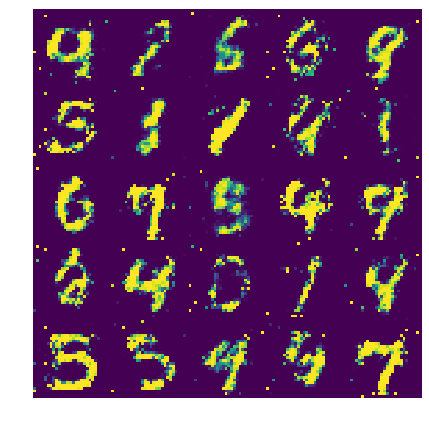

[45/80][128/938] Loss_D: 1.3116 Loss_G: 0.9878 D(x): 0.5003 D(G(z)): 0.4061 / 0.3760
[45/80][328/938] Loss_D: 1.2318 Loss_G: 1.0415 D(x): 0.5051 D(G(z)): 0.3566 / 0.3534
[45/80][528/938] Loss_D: 1.2270 Loss_G: 1.0244 D(x): 0.5552 D(G(z)): 0.4003 / 0.3648
[45/80][728/938] Loss_D: 1.2619 Loss_G: 0.9527 D(x): 0.5130 D(G(z)): 0.3838 / 0.3962
[45/80][928/938] Loss_D: 1.3567 Loss_G: 0.9700 D(x): 0.4609 D(G(z)): 0.3872 / 0.3782


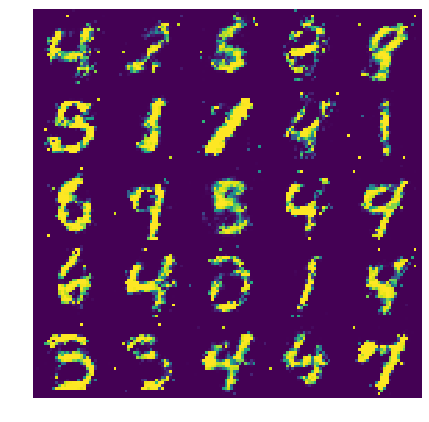

[46/80][190/938] Loss_D: 1.2941 Loss_G: 0.9226 D(x): 0.4819 D(G(z)): 0.3852 / 0.4006
[46/80][390/938] Loss_D: 1.1765 Loss_G: 1.1008 D(x): 0.5086 D(G(z)): 0.3394 / 0.3381
[46/80][590/938] Loss_D: 1.3014 Loss_G: 1.0824 D(x): 0.5603 D(G(z)): 0.4487 / 0.3524
[46/80][790/938] Loss_D: 1.2627 Loss_G: 0.9240 D(x): 0.5166 D(G(z)): 0.3961 / 0.3993


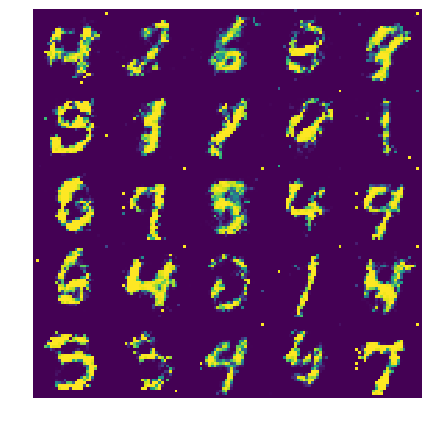

[47/80][52/938] Loss_D: 1.2746 Loss_G: 1.0721 D(x): 0.5634 D(G(z)): 0.4337 / 0.3432
[47/80][252/938] Loss_D: 1.2734 Loss_G: 0.9479 D(x): 0.5226 D(G(z)): 0.4051 / 0.3970
[47/80][452/938] Loss_D: 1.3392 Loss_G: 0.9824 D(x): 0.5425 D(G(z)): 0.4627 / 0.3757
[47/80][652/938] Loss_D: 1.3444 Loss_G: 0.9416 D(x): 0.4445 D(G(z)): 0.3690 / 0.3980
[47/80][852/938] Loss_D: 1.2629 Loss_G: 1.0067 D(x): 0.4851 D(G(z)): 0.3656 / 0.3794


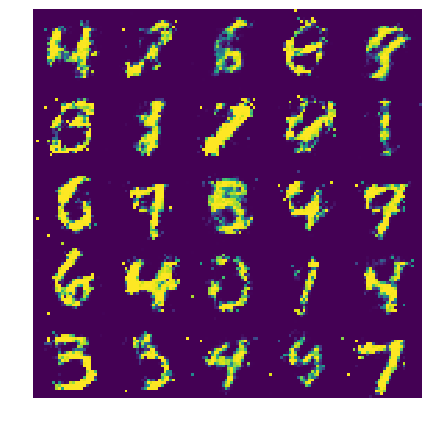

[48/80][114/938] Loss_D: 1.2125 Loss_G: 1.0006 D(x): 0.5353 D(G(z)): 0.3942 / 0.3713
[48/80][314/938] Loss_D: 1.2581 Loss_G: 0.9976 D(x): 0.5077 D(G(z)): 0.3916 / 0.3693
[48/80][514/938] Loss_D: 1.3060 Loss_G: 0.9755 D(x): 0.4770 D(G(z)): 0.3827 / 0.3780
[48/80][714/938] Loss_D: 1.2565 Loss_G: 1.0324 D(x): 0.5638 D(G(z)): 0.4403 / 0.3501
[48/80][914/938] Loss_D: 1.2308 Loss_G: 0.9253 D(x): 0.5115 D(G(z)): 0.3912 / 0.3999


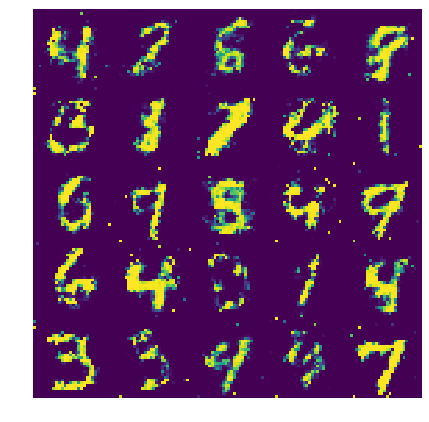

[49/80][176/938] Loss_D: 1.2693 Loss_G: 0.9893 D(x): 0.5143 D(G(z)): 0.4080 / 0.3744
[49/80][376/938] Loss_D: 1.2797 Loss_G: 0.9279 D(x): 0.5041 D(G(z)): 0.4059 / 0.4003
[49/80][576/938] Loss_D: 1.2311 Loss_G: 0.9714 D(x): 0.5221 D(G(z)): 0.3927 / 0.3864
[49/80][776/938] Loss_D: 1.3615 Loss_G: 0.9596 D(x): 0.4430 D(G(z)): 0.3812 / 0.3849


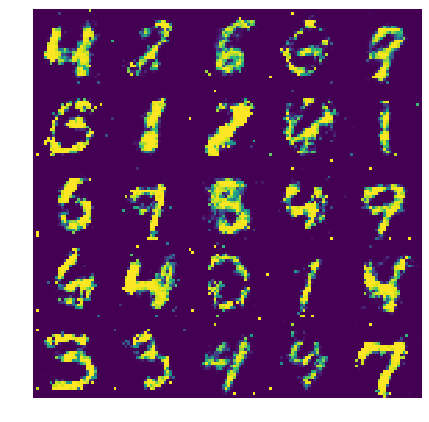

[50/80][38/938] Loss_D: 1.2490 Loss_G: 0.9877 D(x): 0.5360 D(G(z)): 0.4129 / 0.3710
[50/80][238/938] Loss_D: 1.3229 Loss_G: 0.9603 D(x): 0.4877 D(G(z)): 0.4062 / 0.3915
[50/80][438/938] Loss_D: 1.3720 Loss_G: 0.8326 D(x): 0.4238 D(G(z)): 0.3714 / 0.4438
[50/80][638/938] Loss_D: 1.2523 Loss_G: 0.9640 D(x): 0.5257 D(G(z)): 0.4013 / 0.3850
[50/80][838/938] Loss_D: 1.2842 Loss_G: 0.9108 D(x): 0.4528 D(G(z)): 0.3582 / 0.4017


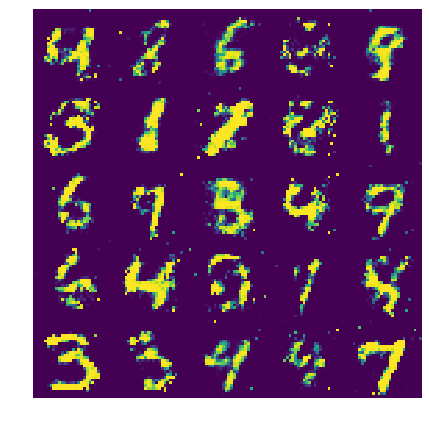

[51/80][100/938] Loss_D: 1.2262 Loss_G: 1.0253 D(x): 0.5288 D(G(z)): 0.3985 / 0.3556
[51/80][300/938] Loss_D: 1.3395 Loss_G: 1.0737 D(x): 0.4800 D(G(z)): 0.4132 / 0.3415
[51/80][500/938] Loss_D: 1.2802 Loss_G: 1.0336 D(x): 0.5058 D(G(z)): 0.4059 / 0.3559
[51/80][700/938] Loss_D: 1.2653 Loss_G: 0.9766 D(x): 0.5533 D(G(z)): 0.4397 / 0.3752
[51/80][900/938] Loss_D: 1.2048 Loss_G: 1.1079 D(x): 0.4947 D(G(z)): 0.3451 / 0.3285


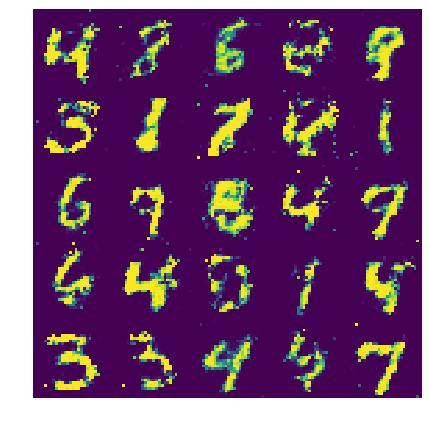

[52/80][162/938] Loss_D: 1.2525 Loss_G: 0.9623 D(x): 0.4886 D(G(z)): 0.3682 / 0.3863
[52/80][362/938] Loss_D: 1.3912 Loss_G: 0.9234 D(x): 0.4787 D(G(z)): 0.4274 / 0.4028
[52/80][562/938] Loss_D: 1.2495 Loss_G: 1.0148 D(x): 0.5068 D(G(z)): 0.3924 / 0.3693
[52/80][762/938] Loss_D: 1.2820 Loss_G: 0.9551 D(x): 0.5199 D(G(z)): 0.4191 / 0.3819


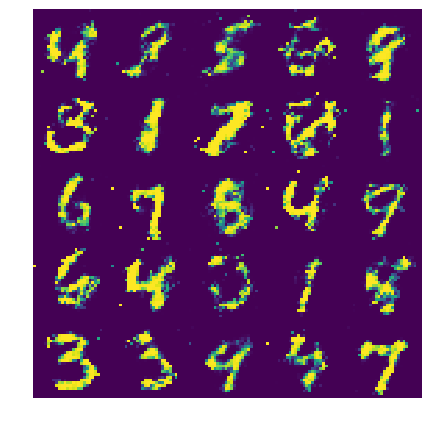

[53/80][24/938] Loss_D: 1.1920 Loss_G: 0.9361 D(x): 0.4790 D(G(z)): 0.3389 / 0.3880
[53/80][224/938] Loss_D: 1.2564 Loss_G: 1.0002 D(x): 0.5136 D(G(z)): 0.3969 / 0.3716
[53/80][424/938] Loss_D: 1.2259 Loss_G: 1.0587 D(x): 0.5256 D(G(z)): 0.3983 / 0.3428
[53/80][624/938] Loss_D: 1.3415 Loss_G: 0.9805 D(x): 0.4975 D(G(z)): 0.4131 / 0.3840
[53/80][824/938] Loss_D: 1.3268 Loss_G: 1.0623 D(x): 0.5297 D(G(z)): 0.4444 / 0.3399


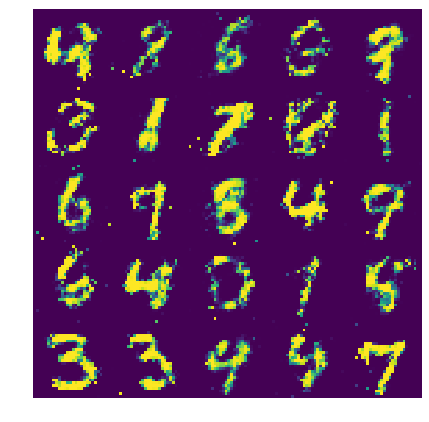

[54/80][86/938] Loss_D: 1.3186 Loss_G: 0.9734 D(x): 0.4954 D(G(z)): 0.4196 / 0.3785
[54/80][286/938] Loss_D: 1.2207 Loss_G: 0.9576 D(x): 0.5157 D(G(z)): 0.3820 / 0.3885
[54/80][486/938] Loss_D: 1.2943 Loss_G: 0.9057 D(x): 0.4411 D(G(z)): 0.3487 / 0.4016
[54/80][686/938] Loss_D: 1.2582 Loss_G: 0.9581 D(x): 0.5150 D(G(z)): 0.4142 / 0.3771
[54/80][886/938] Loss_D: 1.2836 Loss_G: 1.0896 D(x): 0.5431 D(G(z)): 0.4456 / 0.3323


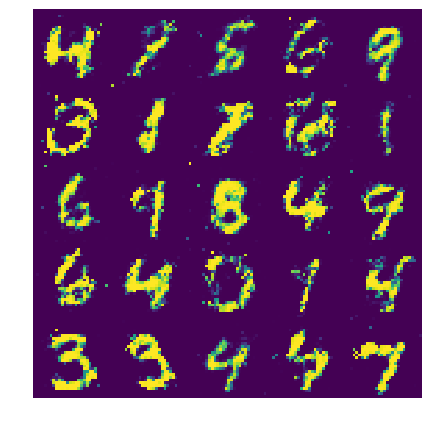

[55/80][148/938] Loss_D: 1.2911 Loss_G: 0.9108 D(x): 0.5135 D(G(z)): 0.4196 / 0.4045
[55/80][348/938] Loss_D: 1.2685 Loss_G: 0.9963 D(x): 0.4960 D(G(z)): 0.3903 / 0.3683
[55/80][548/938] Loss_D: 1.3363 Loss_G: 0.9421 D(x): 0.4806 D(G(z)): 0.4069 / 0.3942
[55/80][748/938] Loss_D: 1.2493 Loss_G: 0.9509 D(x): 0.5147 D(G(z)): 0.4041 / 0.3805


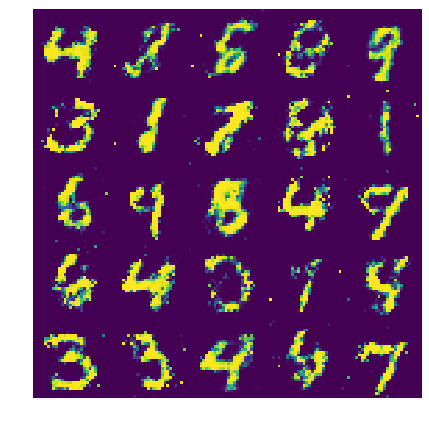

[56/80][10/938] Loss_D: 1.2495 Loss_G: 0.9638 D(x): 0.4937 D(G(z)): 0.3783 / 0.3792
[56/80][210/938] Loss_D: 1.2899 Loss_G: 0.9999 D(x): 0.5216 D(G(z)): 0.4193 / 0.3671
[56/80][410/938] Loss_D: 1.2770 Loss_G: 0.9004 D(x): 0.4919 D(G(z)): 0.3920 / 0.4054
[56/80][610/938] Loss_D: 1.3286 Loss_G: 0.8834 D(x): 0.4702 D(G(z)): 0.3957 / 0.4129
[56/80][810/938] Loss_D: 1.2624 Loss_G: 1.0111 D(x): 0.5020 D(G(z)): 0.3903 / 0.3654


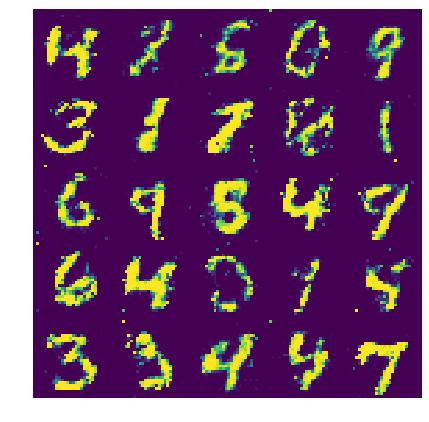

[57/80][72/938] Loss_D: 1.2751 Loss_G: 0.8855 D(x): 0.4400 D(G(z)): 0.3382 / 0.4115
[57/80][272/938] Loss_D: 1.2765 Loss_G: 0.9082 D(x): 0.4885 D(G(z)): 0.3852 / 0.4092
[57/80][472/938] Loss_D: 1.3379 Loss_G: 0.9859 D(x): 0.4882 D(G(z)): 0.4132 / 0.3798
[57/80][672/938] Loss_D: 1.2559 Loss_G: 0.9386 D(x): 0.5102 D(G(z)): 0.4022 / 0.3941
[57/80][872/938] Loss_D: 1.2273 Loss_G: 0.9886 D(x): 0.5481 D(G(z)): 0.4192 / 0.3650


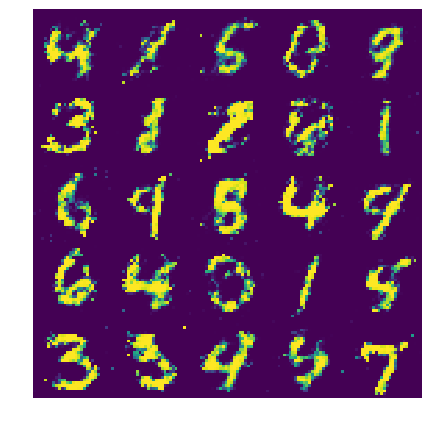

[58/80][134/938] Loss_D: 1.3142 Loss_G: 0.9077 D(x): 0.4790 D(G(z)): 0.3996 / 0.4043
[58/80][334/938] Loss_D: 1.2217 Loss_G: 0.9611 D(x): 0.5130 D(G(z)): 0.3886 / 0.3804
[58/80][534/938] Loss_D: 1.2308 Loss_G: 0.9882 D(x): 0.4878 D(G(z)): 0.3604 / 0.3725
[58/80][734/938] Loss_D: 1.2811 Loss_G: 0.8949 D(x): 0.4755 D(G(z)): 0.3862 / 0.4111
[58/80][934/938] Loss_D: 1.3010 Loss_G: 1.0238 D(x): 0.5231 D(G(z)): 0.4295 / 0.3605


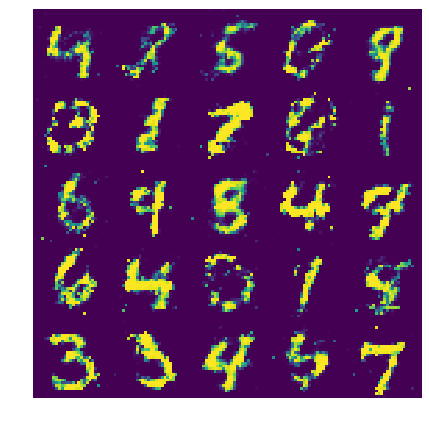

[59/80][196/938] Loss_D: 1.2760 Loss_G: 0.9373 D(x): 0.4470 D(G(z)): 0.3437 / 0.3861
[59/80][396/938] Loss_D: 1.2308 Loss_G: 0.9576 D(x): 0.5163 D(G(z)): 0.4021 / 0.3759
[59/80][596/938] Loss_D: 1.2973 Loss_G: 1.1248 D(x): 0.5055 D(G(z)): 0.4122 / 0.3222
[59/80][796/938] Loss_D: 1.2675 Loss_G: 1.0330 D(x): 0.5247 D(G(z)): 0.4142 / 0.3546


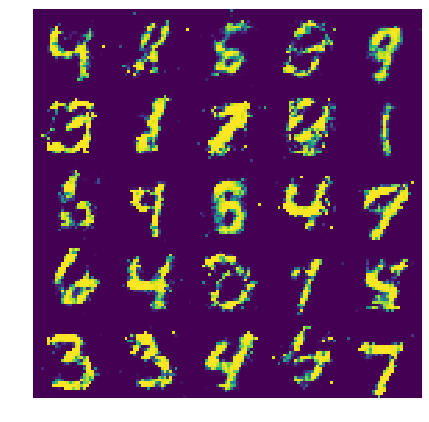

[60/80][58/938] Loss_D: 1.2838 Loss_G: 0.9216 D(x): 0.4932 D(G(z)): 0.4028 / 0.4024
[60/80][258/938] Loss_D: 1.2342 Loss_G: 1.0799 D(x): 0.5384 D(G(z)): 0.4098 / 0.3354
[60/80][458/938] Loss_D: 1.2317 Loss_G: 1.0685 D(x): 0.5270 D(G(z)): 0.3869 / 0.3388
[60/80][658/938] Loss_D: 1.2231 Loss_G: 0.9425 D(x): 0.5072 D(G(z)): 0.3836 / 0.3898
[60/80][858/938] Loss_D: 1.2740 Loss_G: 0.8678 D(x): 0.4832 D(G(z)): 0.3857 / 0.4251


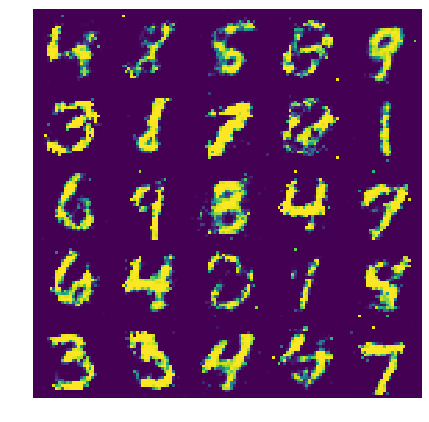

[61/80][120/938] Loss_D: 1.1627 Loss_G: 1.1071 D(x): 0.5345 D(G(z)): 0.3722 / 0.3216
[61/80][320/938] Loss_D: 1.3387 Loss_G: 0.9469 D(x): 0.5507 D(G(z)): 0.4794 / 0.3903
[61/80][520/938] Loss_D: 1.2766 Loss_G: 0.8745 D(x): 0.4927 D(G(z)): 0.3849 / 0.4189
[61/80][720/938] Loss_D: 1.3018 Loss_G: 0.9766 D(x): 0.4738 D(G(z)): 0.3925 / 0.3716
[61/80][920/938] Loss_D: 1.2644 Loss_G: 1.0157 D(x): 0.5372 D(G(z)): 0.4225 / 0.3623


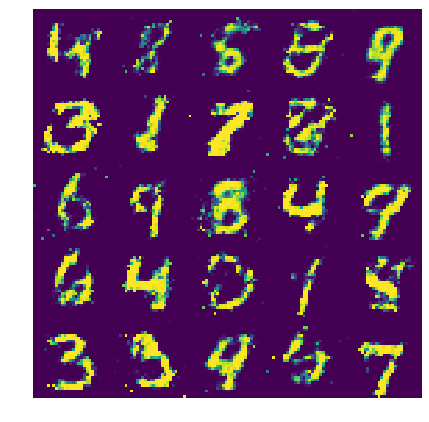

[62/80][182/938] Loss_D: 1.1988 Loss_G: 0.9906 D(x): 0.5279 D(G(z)): 0.3847 / 0.3681
[62/80][382/938] Loss_D: 1.2800 Loss_G: 0.9412 D(x): 0.4896 D(G(z)): 0.3916 / 0.3928
[62/80][582/938] Loss_D: 1.4134 Loss_G: 0.8838 D(x): 0.4639 D(G(z)): 0.4263 / 0.4178
[62/80][782/938] Loss_D: 1.3229 Loss_G: 0.9357 D(x): 0.4954 D(G(z)): 0.4281 / 0.3871


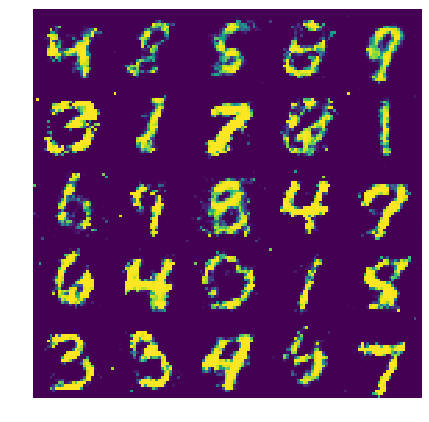

[63/80][44/938] Loss_D: 1.2887 Loss_G: 0.9856 D(x): 0.5082 D(G(z)): 0.4061 / 0.3799
[63/80][244/938] Loss_D: 1.2849 Loss_G: 1.0148 D(x): 0.4921 D(G(z)): 0.3973 / 0.3609
[63/80][444/938] Loss_D: 1.3591 Loss_G: 0.9002 D(x): 0.5414 D(G(z)): 0.4768 / 0.4069
[63/80][644/938] Loss_D: 1.2651 Loss_G: 0.9338 D(x): 0.5117 D(G(z)): 0.4052 / 0.3979
[63/80][844/938] Loss_D: 1.3148 Loss_G: 0.8981 D(x): 0.4915 D(G(z)): 0.4155 / 0.4100


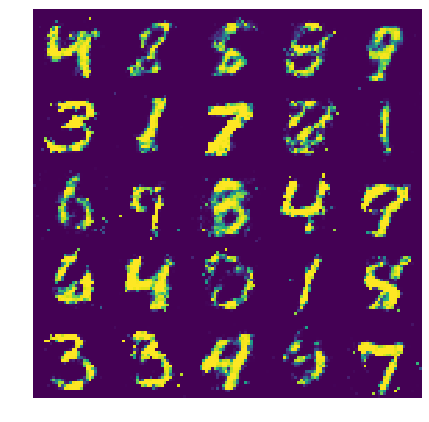

[64/80][106/938] Loss_D: 1.2243 Loss_G: 1.0107 D(x): 0.5360 D(G(z)): 0.4148 / 0.3567
[64/80][306/938] Loss_D: 1.2227 Loss_G: 0.9655 D(x): 0.4888 D(G(z)): 0.3693 / 0.3755
[64/80][506/938] Loss_D: 1.3023 Loss_G: 0.9519 D(x): 0.5234 D(G(z)): 0.4317 / 0.3882
[64/80][706/938] Loss_D: 1.3359 Loss_G: 0.9343 D(x): 0.4698 D(G(z)): 0.3969 / 0.3964
[64/80][906/938] Loss_D: 1.2688 Loss_G: 0.8953 D(x): 0.4903 D(G(z)): 0.3918 / 0.4121


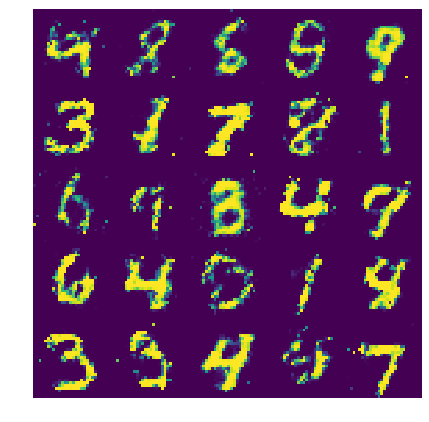

[65/80][168/938] Loss_D: 1.3363 Loss_G: 0.8529 D(x): 0.4829 D(G(z)): 0.4197 / 0.4288
[65/80][368/938] Loss_D: 1.3922 Loss_G: 0.9015 D(x): 0.4631 D(G(z)): 0.4175 / 0.4119
[65/80][568/938] Loss_D: 1.3570 Loss_G: 0.9612 D(x): 0.4315 D(G(z)): 0.3850 / 0.3845
[65/80][768/938] Loss_D: 1.3552 Loss_G: 0.9107 D(x): 0.4437 D(G(z)): 0.3872 / 0.4091


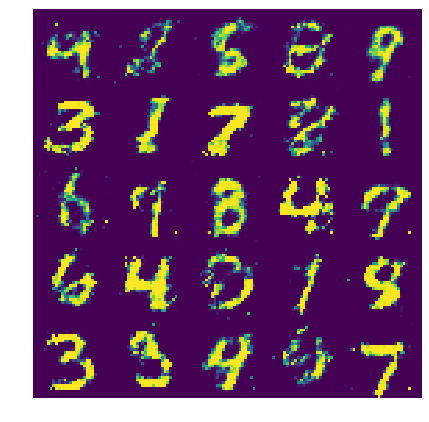

[66/80][30/938] Loss_D: 1.3728 Loss_G: 0.9983 D(x): 0.4442 D(G(z)): 0.3861 / 0.3732
[66/80][230/938] Loss_D: 1.2893 Loss_G: 0.9013 D(x): 0.4543 D(G(z)): 0.3675 / 0.4090
[66/80][430/938] Loss_D: 1.2801 Loss_G: 0.9397 D(x): 0.5604 D(G(z)): 0.4589 / 0.3904
[66/80][630/938] Loss_D: 1.2489 Loss_G: 0.9347 D(x): 0.5169 D(G(z)): 0.4017 / 0.4006
[66/80][830/938] Loss_D: 1.3369 Loss_G: 0.9343 D(x): 0.4783 D(G(z)): 0.4287 / 0.3958


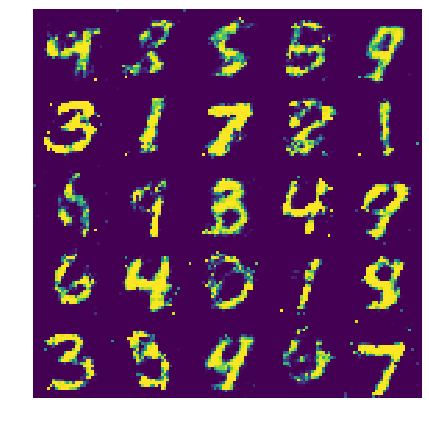

[67/80][92/938] Loss_D: 1.4240 Loss_G: 0.8935 D(x): 0.4803 D(G(z)): 0.4501 / 0.4142
[67/80][292/938] Loss_D: 1.1919 Loss_G: 0.9232 D(x): 0.5479 D(G(z)): 0.3978 / 0.3931
[67/80][492/938] Loss_D: 1.2692 Loss_G: 0.9854 D(x): 0.4811 D(G(z)): 0.3732 / 0.3755
[67/80][692/938] Loss_D: 1.2637 Loss_G: 0.8617 D(x): 0.4928 D(G(z)): 0.3944 / 0.4212
[67/80][892/938] Loss_D: 1.3606 Loss_G: 0.9129 D(x): 0.4648 D(G(z)): 0.4013 / 0.4071


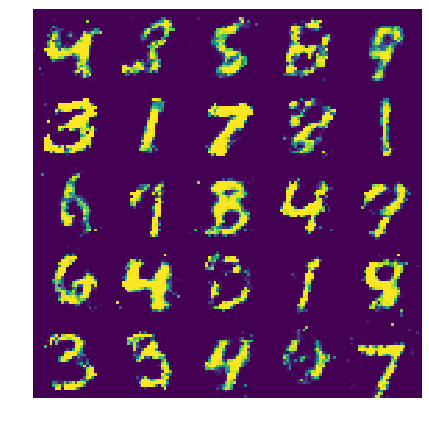

[68/80][154/938] Loss_D: 1.2816 Loss_G: 0.9542 D(x): 0.4830 D(G(z)): 0.3999 / 0.3811
[68/80][354/938] Loss_D: 1.2937 Loss_G: 0.9299 D(x): 0.5380 D(G(z)): 0.4510 / 0.3898
[68/80][554/938] Loss_D: 1.3026 Loss_G: 0.9397 D(x): 0.5351 D(G(z)): 0.4435 / 0.3937
[68/80][754/938] Loss_D: 1.2792 Loss_G: 0.9101 D(x): 0.5008 D(G(z)): 0.4003 / 0.4017


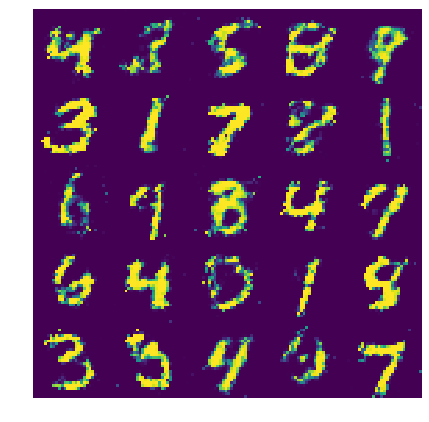

[69/80][16/938] Loss_D: 1.3599 Loss_G: 0.8917 D(x): 0.4879 D(G(z)): 0.4408 / 0.4078
[69/80][216/938] Loss_D: 1.2767 Loss_G: 0.9678 D(x): 0.5153 D(G(z)): 0.4125 / 0.3825
[69/80][416/938] Loss_D: 1.3312 Loss_G: 0.9352 D(x): 0.5378 D(G(z)): 0.4624 / 0.3942
[69/80][616/938] Loss_D: 1.3068 Loss_G: 0.9226 D(x): 0.5506 D(G(z)): 0.4674 / 0.3920
[69/80][816/938] Loss_D: 1.2493 Loss_G: 0.8840 D(x): 0.4758 D(G(z)): 0.3715 / 0.4114


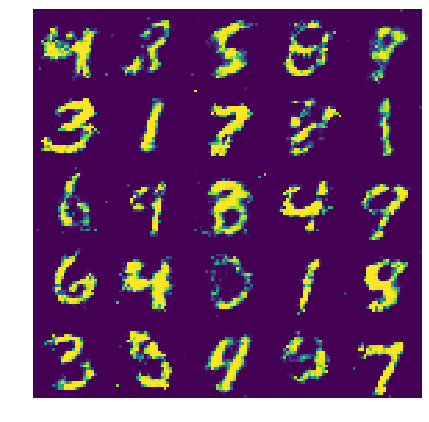

[70/80][78/938] Loss_D: 1.2018 Loss_G: 0.9636 D(x): 0.5641 D(G(z)): 0.4195 / 0.3780
[70/80][278/938] Loss_D: 1.2935 Loss_G: 0.9486 D(x): 0.5167 D(G(z)): 0.4260 / 0.3887
[70/80][478/938] Loss_D: 1.3634 Loss_G: 0.8845 D(x): 0.4314 D(G(z)): 0.3863 / 0.4085
[70/80][678/938] Loss_D: 1.2916 Loss_G: 0.8630 D(x): 0.4461 D(G(z)): 0.3781 / 0.4184
[70/80][878/938] Loss_D: 1.3123 Loss_G: 0.9057 D(x): 0.4847 D(G(z)): 0.4061 / 0.4088


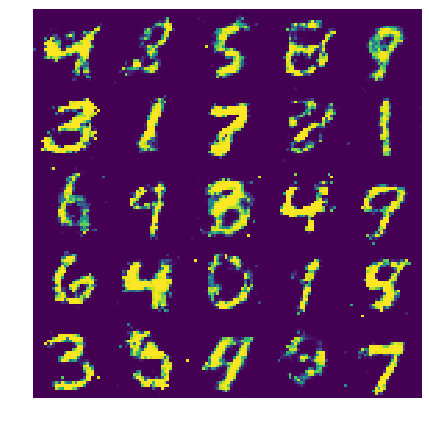

[71/80][140/938] Loss_D: 1.2684 Loss_G: 0.9802 D(x): 0.5179 D(G(z)): 0.4168 / 0.3735
[71/80][340/938] Loss_D: 1.3369 Loss_G: 0.9611 D(x): 0.4836 D(G(z)): 0.4182 / 0.3885
[71/80][540/938] Loss_D: 1.2360 Loss_G: 0.9005 D(x): 0.4788 D(G(z)): 0.3648 / 0.4061
[71/80][740/938] Loss_D: 1.3193 Loss_G: 0.9099 D(x): 0.4667 D(G(z)): 0.3835 / 0.3992


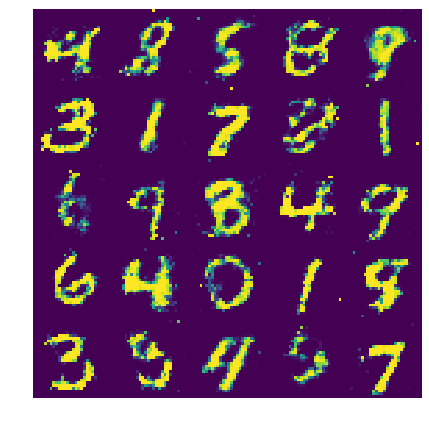

[72/80][2/938] Loss_D: 1.3483 Loss_G: 0.8828 D(x): 0.5058 D(G(z)): 0.4452 / 0.4179
[72/80][202/938] Loss_D: 1.3581 Loss_G: 0.9050 D(x): 0.4707 D(G(z)): 0.4192 / 0.4107
[72/80][402/938] Loss_D: 1.2766 Loss_G: 0.9293 D(x): 0.5080 D(G(z)): 0.4216 / 0.3863
[72/80][602/938] Loss_D: 1.3034 Loss_G: 0.9200 D(x): 0.4872 D(G(z)): 0.3993 / 0.3980
[72/80][802/938] Loss_D: 1.3084 Loss_G: 0.9047 D(x): 0.4640 D(G(z)): 0.3914 / 0.4010


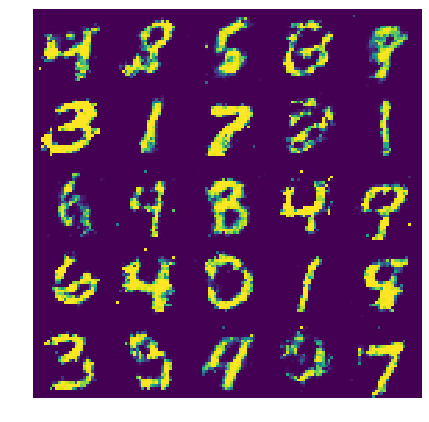

[73/80][64/938] Loss_D: 1.3037 Loss_G: 1.0394 D(x): 0.5055 D(G(z)): 0.4224 / 0.3485
[73/80][264/938] Loss_D: 1.2752 Loss_G: 0.8907 D(x): 0.4775 D(G(z)): 0.3962 / 0.4066
[73/80][464/938] Loss_D: 1.3820 Loss_G: 0.8908 D(x): 0.4726 D(G(z)): 0.4373 / 0.4096
[73/80][664/938] Loss_D: 1.2982 Loss_G: 0.9803 D(x): 0.5300 D(G(z)): 0.4352 / 0.3827
[73/80][864/938] Loss_D: 1.2786 Loss_G: 0.9480 D(x): 0.5349 D(G(z)): 0.4409 / 0.3811


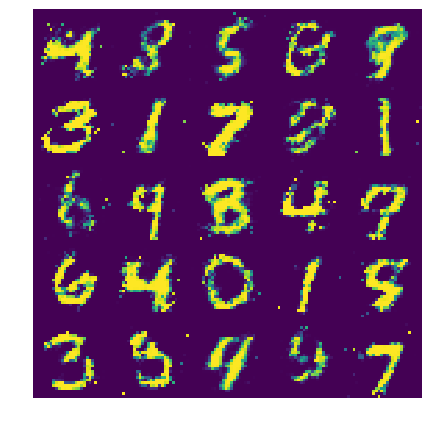

[74/80][126/938] Loss_D: 1.2083 Loss_G: 0.9877 D(x): 0.5224 D(G(z)): 0.3840 / 0.3704
[74/80][326/938] Loss_D: 1.3025 Loss_G: 0.8564 D(x): 0.4437 D(G(z)): 0.3680 / 0.4303
[74/80][526/938] Loss_D: 1.3052 Loss_G: 1.0199 D(x): 0.5347 D(G(z)): 0.4432 / 0.3603
[74/80][726/938] Loss_D: 1.2487 Loss_G: 0.9551 D(x): 0.4660 D(G(z)): 0.3557 / 0.3853
[74/80][926/938] Loss_D: 1.3147 Loss_G: 0.9723 D(x): 0.4659 D(G(z)): 0.3918 / 0.3796


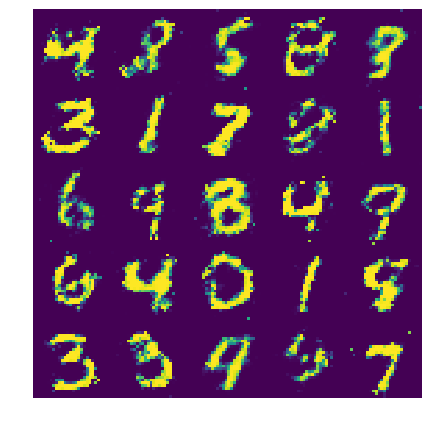

[75/80][188/938] Loss_D: 1.3478 Loss_G: 0.8989 D(x): 0.5323 D(G(z)): 0.4712 / 0.4105
[75/80][388/938] Loss_D: 1.3099 Loss_G: 0.8935 D(x): 0.4732 D(G(z)): 0.3988 / 0.4106
[75/80][588/938] Loss_D: 1.2779 Loss_G: 0.8306 D(x): 0.5096 D(G(z)): 0.4264 / 0.4371
[75/80][788/938] Loss_D: 1.3369 Loss_G: 0.9047 D(x): 0.4649 D(G(z)): 0.4132 / 0.4045


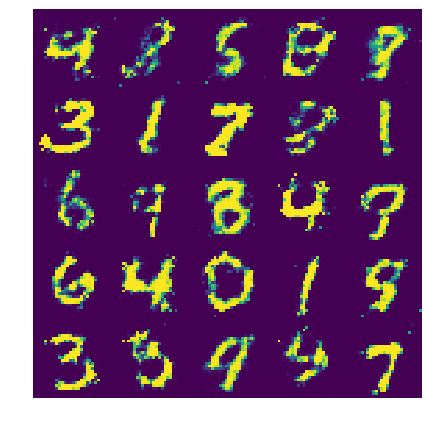

[76/80][50/938] Loss_D: 1.2457 Loss_G: 0.9225 D(x): 0.5114 D(G(z)): 0.3985 / 0.3979
[76/80][250/938] Loss_D: 1.3182 Loss_G: 0.8809 D(x): 0.4316 D(G(z)): 0.3487 / 0.4130
[76/80][450/938] Loss_D: 1.2892 Loss_G: 0.9878 D(x): 0.4684 D(G(z)): 0.3728 / 0.3706
[76/80][650/938] Loss_D: 1.3335 Loss_G: 0.9154 D(x): 0.5238 D(G(z)): 0.4548 / 0.3975
[76/80][850/938] Loss_D: 1.2146 Loss_G: 0.9781 D(x): 0.5477 D(G(z)): 0.4113 / 0.3761


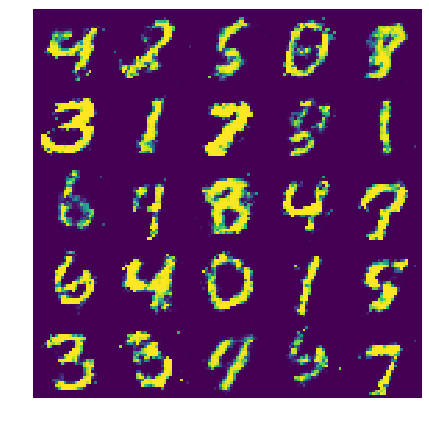

[77/80][112/938] Loss_D: 1.2845 Loss_G: 0.8759 D(x): 0.4906 D(G(z)): 0.3998 / 0.4217
[77/80][312/938] Loss_D: 1.3470 Loss_G: 0.9228 D(x): 0.4257 D(G(z)): 0.3652 / 0.3972
[77/80][512/938] Loss_D: 1.3115 Loss_G: 0.9691 D(x): 0.5109 D(G(z)): 0.4240 / 0.3819
[77/80][712/938] Loss_D: 1.2800 Loss_G: 0.9788 D(x): 0.4716 D(G(z)): 0.3810 / 0.3748
[77/80][912/938] Loss_D: 1.2562 Loss_G: 0.9485 D(x): 0.5016 D(G(z)): 0.3991 / 0.3830


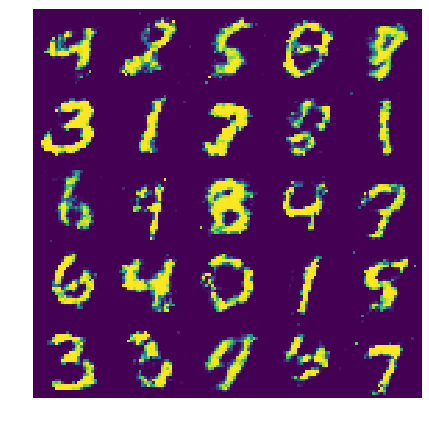

[78/80][174/938] Loss_D: 1.2819 Loss_G: 0.9175 D(x): 0.4512 D(G(z)): 0.3585 / 0.3978
[78/80][374/938] Loss_D: 1.2366 Loss_G: 0.9724 D(x): 0.5479 D(G(z)): 0.4295 / 0.3736
[78/80][574/938] Loss_D: 1.3815 Loss_G: 0.9076 D(x): 0.4400 D(G(z)): 0.3974 / 0.4107
[78/80][774/938] Loss_D: 1.3360 Loss_G: 0.9266 D(x): 0.4939 D(G(z)): 0.4234 / 0.4008


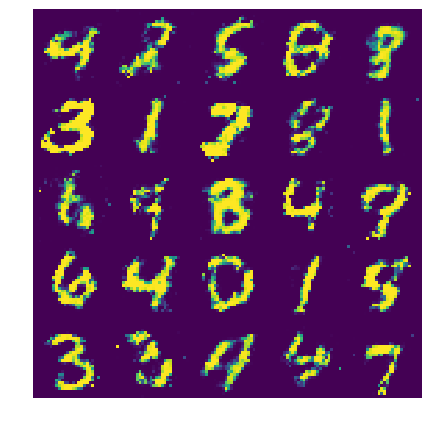

[79/80][36/938] Loss_D: 1.2828 Loss_G: 0.9302 D(x): 0.5209 D(G(z)): 0.4369 / 0.3952
[79/80][236/938] Loss_D: 1.3385 Loss_G: 0.9527 D(x): 0.4818 D(G(z)): 0.4221 / 0.3917
[79/80][436/938] Loss_D: 1.2874 Loss_G: 0.9274 D(x): 0.5317 D(G(z)): 0.4371 / 0.3971
[79/80][636/938] Loss_D: 1.3249 Loss_G: 0.8694 D(x): 0.4617 D(G(z)): 0.3962 / 0.4149
[79/80][836/938] Loss_D: 1.3241 Loss_G: 0.8683 D(x): 0.4685 D(G(z)): 0.3973 / 0.4248


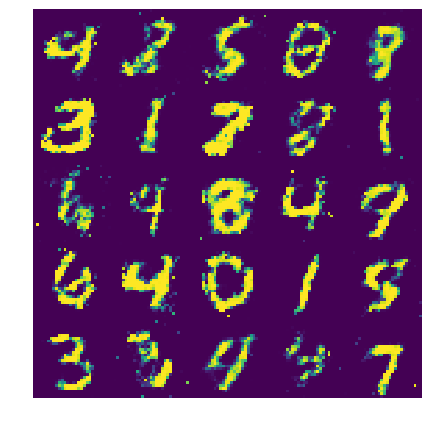

[80/80][98/938] Loss_D: 1.2779 Loss_G: 0.8844 D(x): 0.4954 D(G(z)): 0.3918 / 0.4165
[80/80][298/938] Loss_D: 1.3626 Loss_G: 0.9821 D(x): 0.4698 D(G(z)): 0.4144 / 0.3783
[80/80][498/938] Loss_D: 1.2494 Loss_G: 1.0390 D(x): 0.5209 D(G(z)): 0.4012 / 0.3477
[80/80][698/938] Loss_D: 1.2726 Loss_G: 0.9315 D(x): 0.4934 D(G(z)): 0.3932 / 0.3971
[80/80][898/938] Loss_D: 1.2781 Loss_G: 0.9191 D(x): 0.4738 D(G(z)): 0.3770 / 0.4009


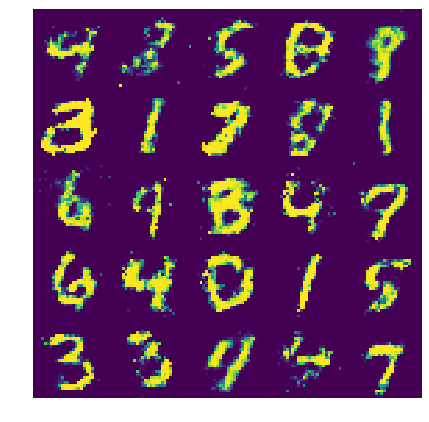

In [8]:
# You can get pretty good results with 80 epochs. More is better.
epochs = 80

step = 0
for epoch in range(epochs):
    for ii, (real_images, _) in enumerate(train_loader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Sometimes you'll get not full batches, so need to be flexible
        batch_size = real_images.size(0)
        
        # Train discriminator on real images
        real_images = real_images.to(device)
        labels = torch.full((batch_size, 1), real_label, device=device)
        netD.zero_grad()
        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()
        
        # For monitoring training progress
        D_x = output.mean().item()

        # Train with fake
        noise = torch.randn(batch_size, nz, device=device)
        fake = netG(noise)
        # Changing labels in-place because gotta go fast
        labels.fill_(fake_label)
        # Detach here so we don't backprop through to the generator
        output = netD(fake.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        optimizerD.step()
        
        # For monitoring training progress
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labels.fill_(real_label)  # Real labels for fake images
        output = netD(fake)
        errG = criterion(output, labels)
        errG.backward()
        optimizerG.step()
        
        # For monitoring training progress
        D_G_z2 = output.mean().item()
        
        if step % 200 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch + 1, epochs, ii, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        step += 1
    else:
        valid_image = netG(fixed_noise)
        image_grid(valid_image)
        plt.show()

After training, I'm displaying generate images from the final model and real images, for comparison.

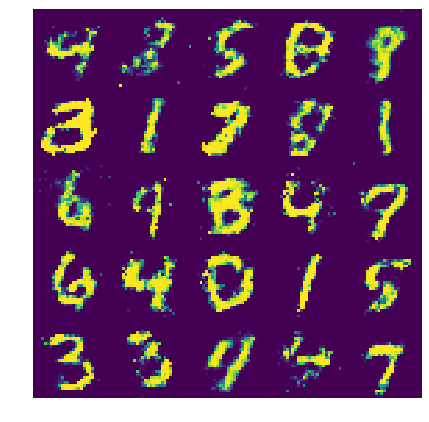

In [9]:
image_grid(valid_image)

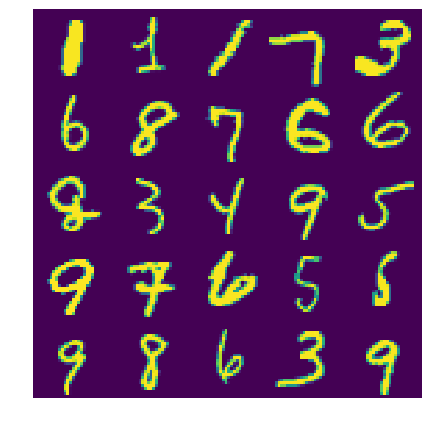

In [10]:
real_images, _ = next(iter(train_loader))
image_grid(real_images[:25])

# Save networks

Here we can save the networks if we want to load them again.

In [11]:
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')

# Save generated images

Finally we want to generate a bunch of images and save them. For the kernel to work properly, we'll need to make sure the images are archived in a zip file and the individual images are deleted. Also, torchvision provides a utility function that speeds up saving the images.

In [12]:
!mkdir images

In [13]:
from torchvision.utils import save_image

In [14]:
noise = torch.randn(10000, nz, device=device)
image_tensors = netG(noise)
# Move values back to be between 0 and 1
image_tensors = (image_tensors * 0.5 + 0.5)
for ix, image in enumerate(image_tensors):
    save_image(image, f'images/image_{ix:05d}.png')